This notebook performs response-weighted analysis on the activation outputs of a traditional MNIST model.

# Initialisations

In [100]:
from rwa_functions import *  # custom module for Response-Weighted Analysis

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import init
import torch.fx

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import mutual_info_regression
from sklearn.metrics import mutual_info_score

import math
import numpy as np
import matplotlib.pyplot as plt
import pickle
from tqdm import tqdm

In [2]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, 5, 1)
        self.conv2 = nn.Conv2d(16, 32, 5, 1)
        self.dropout1 = nn.Dropout(0.25)
        self.dropout2 = nn.Dropout(0.5)
        self.fc1 = nn.Linear(10*10*32, 64)  
        self.fc2 = nn.Linear(64, 10)

    def forward(self, x):
        x1 = self.conv1(x)
        x = F.relu(x1)
        x2 = self.conv2(x)
        x = F.relu(x2)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        output = F.log_softmax(x, dim=1)
        return x1, x2


In [3]:
net = Net()
net.eval()
modelfilename = './model_data/mnist_model/mnist_cnn.pt'
net.load_state_dict(torch.load(modelfilename)) # load the model
print(net)
print(net.state_dict().keys())

Net(
  (conv1): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1))
  (dropout1): Dropout(p=0.25, inplace=False)
  (dropout2): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=3200, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=10, bias=True)
)
odict_keys(['conv1.weight', 'conv1.bias', 'conv2.weight', 'conv2.bias', 'fc1.weight', 'fc1.bias', 'fc2.weight', 'fc2.bias'])


# Weights Visualisation

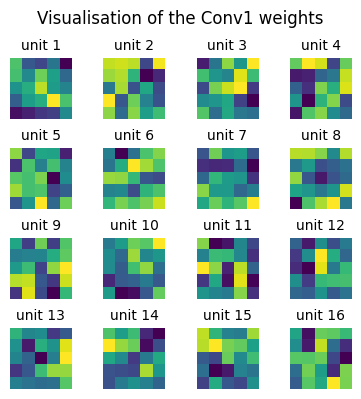

In [4]:
# conv1 weights (kernels) visualisation - 16 units
w1 = net.state_dict()['conv1.weight']
w1 = np.transpose(w1, (0, 2, 3, 1)) # transform to visualisation format in rgb state

# visualise the weights as RGB images
for i in range(w1.shape[0]): # loop through each unit
    plt.subplot(4, 4, i+1)
    plt.axis('off')
    to_show = (w1[i] - w1[i].min()) / (w1[i].max() - w1[i].min()) # normalise to [0, 1]
    plt.imshow(to_show)
    plt.title('unit ' + str(i+1), fontsize=10)
plt.suptitle('Visualisation of the Conv1 weights')
plt.tight_layout()
plt.gcf().set_size_inches(4, 4)
plt.show()

# Lab Recording Room

In [521]:
# Experiment settings
batch_num = 100
batch_size = 500
zero_mean = True
layer = 'conv2'
dims = [28, 1] # 64 x 64 noise input, 3 channels

# Get centre locations of receptive field to record activation (arbitrary choice)
net.eval()
X = (torch.rand(batch_size, dims[1], dims[0], dims[0]) - 0.5) * 255 # colored noise pattern ensemble, zero mean
x1,x2 = net(X) # forward pass to get the activation map
if layer == 'conv1':
    nR,nC = x1[0,0,:,:].shape
elif layer == 'conv2':
    nR,nC = x2[0,0,:,:].shape
print(f'Size of {layer} activation map: ({nR}, {nC})')
locs = [int(round(float(nR)/2.0)), int(round(float(nC)/2.0))] # location of the centre pixel
print(f'r, c centre locations of the receptive fields are ({locs[0]}, {locs[1]})')

# Recording
if layer == 'conv1':
    act_conv1, noise1 = ActRecorder(layer, net, 'mnist', locs, dims, batch_num, batch_size, zero_mean = zero_mean)
    print(f'min, max and mean of noise: {noise1.min(), noise1.max(), noise1.mean()}')
    # Remove biases
    for unit in range(act_conv1.shape[0]):
        act_conv1[unit] -= net.state_dict()['conv1.bias'][unit]
        
elif layer == 'conv2':
    act_conv2, noise2 = ActRecorder(layer, net, 'mnist', locs, dims, batch_num, batch_size, zero_mean = zero_mean)
    print(f'min, max and mean of noise: {noise2.min(), noise2.max(), noise2.mean()}')
    # Remove biases
    for unit in range(act_conv2.shape[0]):
        act_conv2[unit] -= net.state_dict()['conv2.bias'][unit]

Size of conv2 activation map: (20, 20)
r, c centre locations of the receptive fields are (10, 10)


100%|██████████| 100/100 [00:07<00:00, 14.10it/s]


Activation recording complete.


100%|██████████| 32/32 [00:00<00:00, 294.92it/s]


Shape of activation response list: torch.Size([32, 50000])
Shape of noise list: torch.Size([50000, 28, 28, 1])
min, max and mean of noise: (tensor(-127.5000), tensor(127.5000), tensor(0.0064))


Save the input and output

In [452]:
path_dict = {True: '_0mean', False:'', 'conv1': 1, 'conv2': 2}

In [400]:
# Conv1
layer = 'conv1'
torch.save(act_conv1, f'./rwa_data/mnist/mnist_rand{path_dict[zero_mean]}/act{path_dict[layer]}.pt')
torch.save(noise1, f'./rwa_data/mnist/mnist_rand{path_dict[zero_mean]}/noise{path_dict[layer]}.pt')

In [522]:
# Conv2
layer = 'conv2'
torch.save(act_conv2, f'./rwa_data/mnist/mnist_rand{path_dict[zero_mean]}/act{path_dict[layer]}.pt')
torch.save(noise2, f'./rwa_data/mnist/mnist_rand{path_dict[zero_mean]}/noise{path_dict[layer]}.pt')

# Conv1 - Zero Mean [-127.5, 127,5]

In [8]:
# load existing data if already recorded
path_dict = {True: '_0mean', False:'', 'conv1': 1, 'conv2': 2}

batch_num = 100
batch_size = 500
zero_mean = True
layer = 'conv1'

act_conv1 = torch.load(f'./rwa_data/mnist/mnist_rand{path_dict[zero_mean]}/act{path_dict[layer]}.pt')
noise1 = torch.load(f'./rwa_data/mnist/mnist_rand{path_dict[zero_mean]}/noise{path_dict[layer]}.pt')

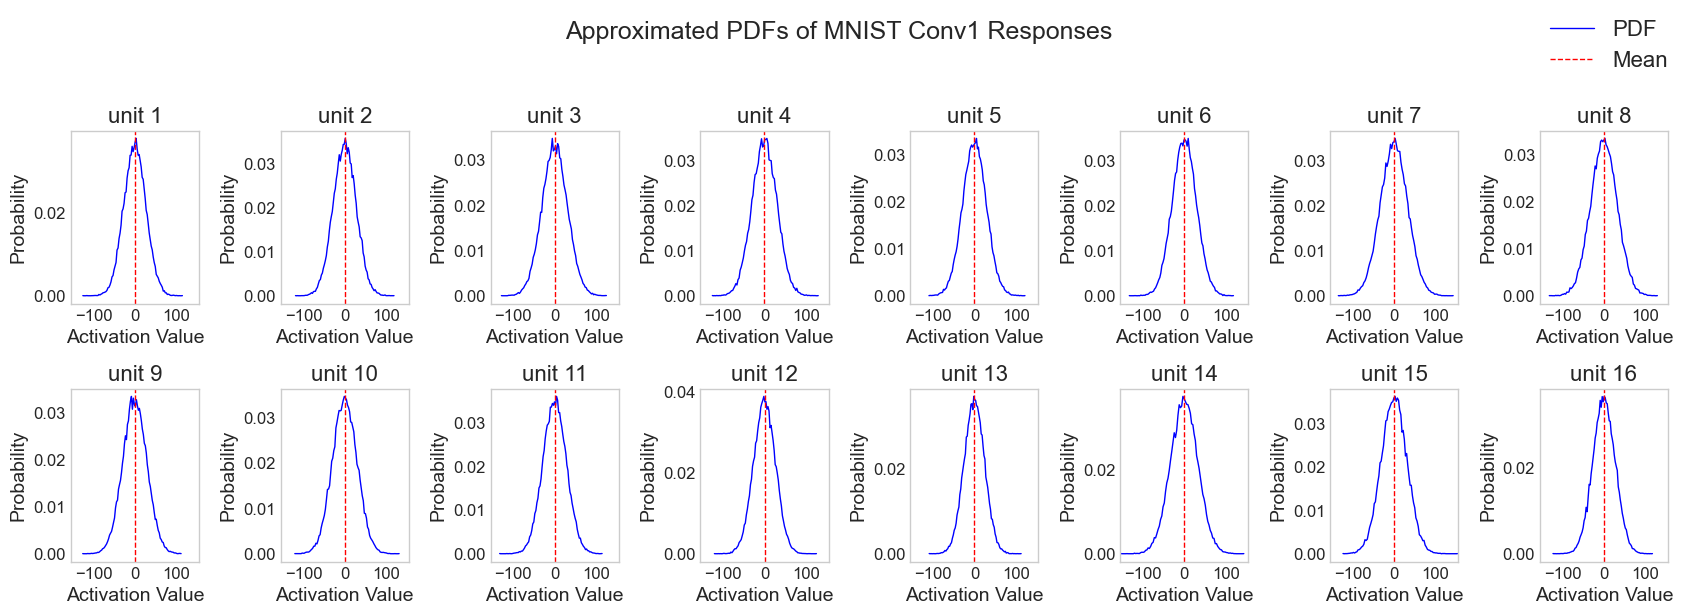

In [293]:
# PDFs of conv1 responses
# gaussian shape is a result of convolution
plt.style.use('seaborn-v0_8-whitegrid')
for i in range(act_conv1.shape[0]):
    plt.subplot(4, 8, i+1)
    plt.xlim(act_conv1.min(), act_conv1.max())
    
    if act_conv1[i][act_conv1[i] != 0].shape[0] != 0: # if unit is not dead
        counts, bin_edges = np.histogram(act_conv1[i], bins=100)
        pdf = counts / sum(counts) # normalise the counts to get the PDF
        bin_centers = (bin_edges[1:] + bin_edges[:-1]) / 2
        plt.plot(bin_centers, pdf, color='blue', linewidth=1)
        plt.xlabel('Activation Value', fontsize=14)
        plt.ylabel('Probability', fontsize=14)
        plt.axvline(act_conv1[i].mean(), color='red', linestyle='dashed', linewidth=1)
        plt.title('unit ' + str(i+1), fontsize=16)
    else:
        # plot shows text saying 'inactive'
        plt.text(0.5, 0.5, 'inactive', horizontalalignment='center', verticalalignment='center')
        plt.title('unit ' + str(i+1), fontsize=16)
        plt.axis('off')
    plt.gcf().set_size_inches(14, 9)
    
    # turn off gird
    plt.grid(False)
    # set xtick and ytick size
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)

plt.suptitle('Approximated PDFs of MNIST Conv1 Responses', fontsize=18)

# add a legend
plt.figlegend(['PDF', 'Mean'], loc='upper right', fontsize=16)

# add a boundary box to the legend
# change figure size
plt.gcf().set_size_inches(17, 11)
plt.tight_layout()

# add space below the title
plt.subplots_adjust(top=0.88)
plt.show()

RWA

In [44]:
# RWA - unbiased RF estimation, absolute false
rf1 = RWA(act_conv1, noise1, absolute=False)
print(rf1.shape)

100%|██████████| 800000/800000 [00:12<00:00, 62130.99it/s]


Shape of receptive field list: torch.Size([16, 28, 28, 1])
torch.Size([16, 28, 28, 1])


In [45]:
# Save the RWA data
torch.save(rf1, f'./rwa_data/mnist/mnist_rand{path_dict[zero_mean]}/rf{path_dict[layer]}.pt')

-605.781 510.853


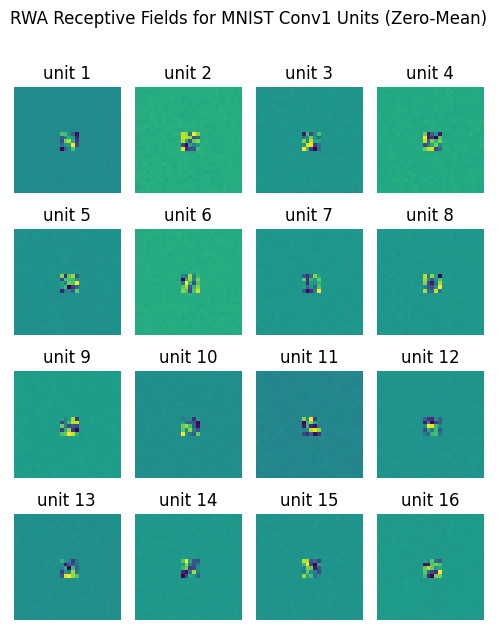

In [317]:
# Absolute = False - Visualise the RWA output as image plots
plt.style.use('default')
for i in range(rf1.shape[0]):
    plt.subplot(4, 4, i+1) # nrows, ncols, index
    plt.axis('off')
    to_show = rf1[i]
    
    # if the unit is not dead (positive activation values)
    if act_conv1[i][act_conv1[i] > 0].shape[0] != 0: # negative activation values are dead units
        to_show = (to_show - to_show.min()) / (to_show.max() - to_show.min()) # normalise to [0, 1]
        plt.imshow(to_show)
    else:
        # show a black image
        plt.imshow(np.zeros((rf1.shape[1], rf1.shape[2], rf1.shape[3])))
    plt.title(f'unit {str(i+1)}', fontsize=12)
    plt.gcf().set_size_inches(7, 7)
    
# title for the entire plot
plt.suptitle(f'RWA Receptive Fields for MNIST Conv1 Units (Zero-Mean)', fontsize=12)
print(np.round(float(rf1.min()), 3), np.round(float(rf1.max()), 3))
# increase the spacing between subplots
# change figure size
plt.gcf().set_size_inches(5, 6.5)
plt.tight_layout()
plt.subplots_adjust(top=0.88)
plt.show()

Receptive Field Estimation via Pearson Correlation

In [48]:
# Absolute = false - gets the correlation between the RF and the noise for each unit
rf_corr1 = torch.zeros(rf1.shape)
for i in range(rf1.shape[3]): # loop through each channel
    rf_corr1[:, :, :, i] = CorrRWA(act_conv1, noise1[:, :, :, i])

100%|██████████| 12544/12544 [00:11<00:00, 1084.71it/s]


In [49]:
# Save the RWA data
torch.save(rf_corr1, f'./rwa_data/mnist/mnist_rand{path_dict[zero_mean]}/rf_corr{path_dict[layer]}.pt')

-0.494 0.398


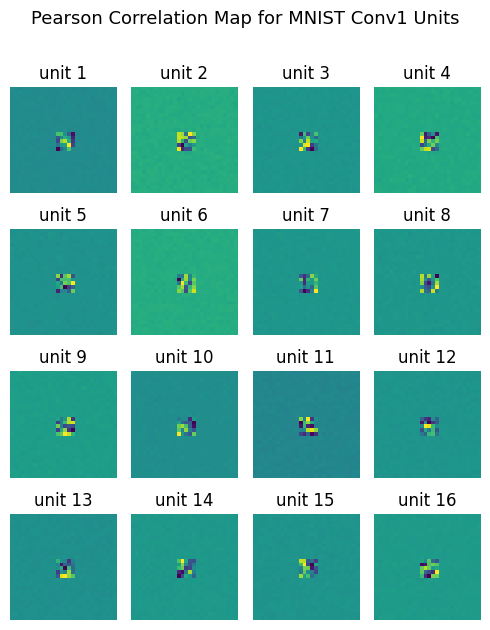

In [318]:
# Absolute = False - Visualise the RWA output as image plots
for i in range(rf1.shape[0]):
    plt.subplot(4, 4, i+1) # nrows, ncols, index
    plt.axis('off')
    to_show = rf_corr1[i]
    
    # if the unit is not dead (positive activation values)
    if act_conv1[i][act_conv1[i] > 0].shape[0] != 0: # negative activation values are dead units
        to_show = (to_show - to_show.min()) / (to_show.max() - to_show.min()) # normalise to [0, 1]
        plt.imshow(to_show)
    else:
        # show a black image
        plt.imshow(np.zeros((rf1.shape[1], rf1.shape[2], rf1.shape[3])))
    plt.title(f'unit {str(i+1)}', fontsize=12)
    plt.gcf().set_size_inches(7, 7)
    
# title for the entire plot
plt.suptitle(f'Pearson Correlation Map for MNIST Conv1 Units', fontsize=13)
print(np.round(float(rf_corr1.min()), 3), np.round(float(rf_corr1.max()), 3))
# change figure size
plt.gcf().set_size_inches(5, 6.5)
plt.tight_layout()
plt.subplots_adjust(top=0.88)
plt.show()

RF Cropping via Pearson Correlation Mask


In [69]:
# calculate the Pearson correlation between the RFs and the input noise and accumulate to obtain mask for cropping
correlation1 = torch.zeros(rf1.shape[1], rf1.shape[2], rf1.shape[3])
for i in range(rf1.shape[3]):
    correlation1[:, :, i] = CorrMask(noise1[:, :, :, i], act_conv1)

100%|██████████| 12544/12544 [00:12<00:00, 1039.60it/s]


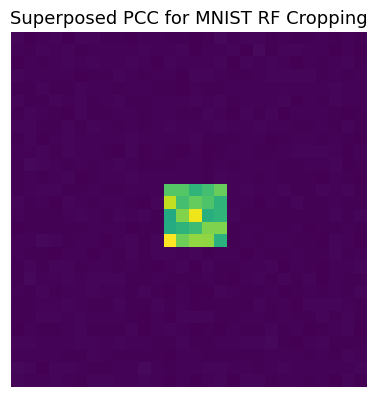

In [347]:
# Display the correlation mask
plt.style.use('default')
to_show = (correlation1 - correlation1.min()) / (correlation1.max() - correlation1.min())
plt.axis('off')
plt.imshow(to_show)
plt.title(f'Superposed PCC for MNIST RF Cropping', fontsize=13)

In [77]:
# save the correlation data
torch.save(correlation1, f'./rwa_data/mnist/mnist_rand{path_dict[zero_mean]}/correlation{path_dict[layer]}.pt')

In [78]:
# crop the RFs
# Threshold for cropping automatically set at 0.01
rf_cropped1 = []
for i in range(rf1.shape[3]): # loop through each channel
    tmp, mask = RfCrop(correlation1[:, :, i], rf1[:, :, :, i]) # crop the RFs
    rf_cropped1.append(tmp)
rf_cropped1 = torch.stack(rf_cropped1, dim=3)

Text(0.5, 1.0, 'Correlation Mask for MNIST RF Cropping')

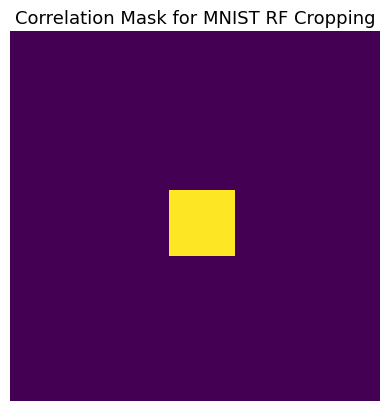

In [84]:
plt.axis('off')

plt.imshow(mask)
plt.title(f'Correlation Mask for MNIST RF Cropping', fontsize=13)

-0.494 0.398


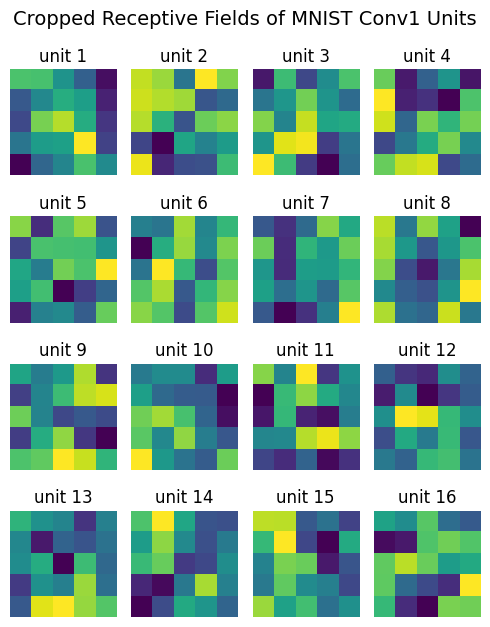

In [320]:
# Absolute = False - Visualise the RWA output as image plots
for i in range(rf1.shape[0]):
    plt.subplot(4, 4, i+1) # nrows, ncols, index
    plt.axis('off')
    to_show = rf_cropped1[i]
    
    # if the unit is not dead (positive activation values)
    if act_conv1[i][act_conv1[i] > 0].shape[0] != 0: # negative activation values are dead units
        to_show = (to_show - to_show.min()) / (to_show.max() - to_show.min()) # normalise to [0, 1]
        plt.imshow(to_show)
    else:
        # show a black image
        plt.imshow(np.zeros((rf1.shape[1], rf1.shape[2], rf1.shape[3])))
    plt.title(f'unit {str(i+1)}', fontsize=12)
    plt.gcf().set_size_inches(6, 6)
    
# title for the entire plot
plt.suptitle(f'Cropped Receptive Fields of MNIST Conv1 Units', fontsize=14)
print(np.round(float(rf_corr1.min()), 3), np.round(float(rf_corr1.max()), 3))
# change figure size
plt.gcf().set_size_inches(5, 6.5)
plt.tight_layout()
plt.show()

In [90]:
# save the cropped RFs
torch.save(rf_cropped1, f'./rwa_data/mnist/mnist_rand{path_dict[zero_mean]}/rf_cropped{path_dict[layer]}.pt')

Mutual Information

In [91]:
print(noise1[:, 0, 0].flatten().shape) # one pixel noise
print(act_conv1[0].flatten().shape) # one unit activation

torch.Size([50000])
torch.Size([50000])


In [103]:
# round every number in noise1 to nearest whole number
noise1_ = np.round(noise1)
act_conv1_ = np.round(act_conv1)

In [124]:
num_units = act_conv1.shape[0]
mi1 = torch.zeros((num_units, noise1.shape[1], noise1.shape[2])) # single channel

with tqdm(total = num_units * noise1.shape[1] * noise1.shape[2]) as pbar:
    for i in range(num_units):
        for j in range(noise1.shape[1]):
            for k in range(noise1.shape[2]): # go through each pixel
                mi1[i, j, k] = mutual_info_score(noise1_[:, j, k].flatten(), act_conv1_[i].flatten())
                pbar.update(1)

100%|██████████| 12544/12544 [04:25<00:00, 47.27it/s]


In [137]:
# save the cropped RFs
torch.save(mi1, f'./rwa_data/mnist/mnist_rand{path_dict[zero_mean]}/mi{path_dict[layer]}.pt')

-0.494 0.398


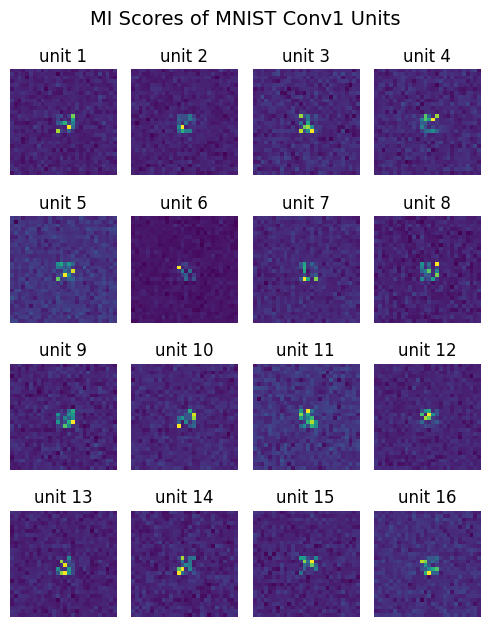

In [322]:
# Absolute = False - Visualise the RWA output as image plots
for i in range(rf1.shape[0]):
    plt.subplot(4, 4, i+1) # nrows, ncols, index
    plt.axis('off')
    to_show = mi1[i]
    
    # if the unit is not dead (positive activation values)
    if act_conv1[i][act_conv1[i] > 0].shape[0] != 0: # negative activation values are dead units
        to_show = (to_show - to_show.min()) / (to_show.max() - to_show.min()) # normalise to [0, 1]
        plt.imshow(to_show)
    else:
        # show a black image
        plt.imshow(np.zeros((rf1.shape[1], rf1.shape[2], rf1.shape[3])))
    plt.title(f'unit {str(i+1)}', fontsize=12)
    plt.gcf().set_size_inches(6, 6)
    
# title for the entire plot
plt.suptitle(f'MI Scores of MNIST Conv1 Units', fontsize=14)
print(np.round(float(rf_corr1.min()), 3), np.round(float(rf_corr1.max()), 3))
# change figure size
plt.gcf().set_size_inches(5, 6.5)
plt.tight_layout()
plt.show()

In [130]:
# crop the RFs
# Threshold for cropping automatically set at 0.01
mi_cropped1, _ = RfCrop(correlation1[:, :, 0], mi1[:, :, :]) # crop the RFs

-0.494 0.398


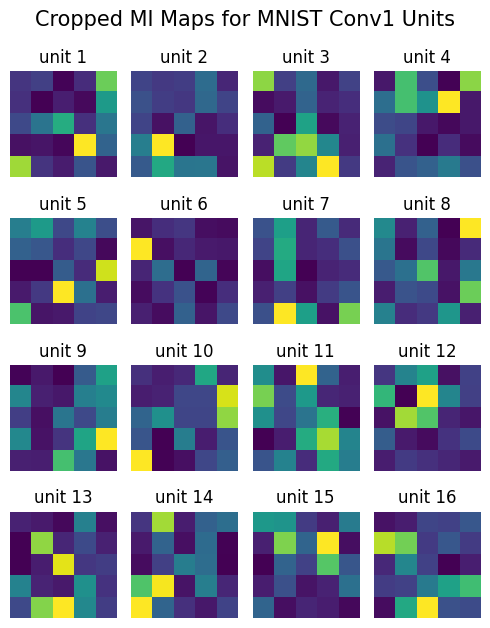

In [323]:
# Absolute = False - Visualise the RWA output as image plots
for i in range(rf1.shape[0]):
    plt.subplot(4, 4, i+1) # nrows, ncols, index
    plt.axis('off')
    to_show = mi_cropped1[i]
    
    # if the unit is not dead (positive activation values)
    if act_conv1[i][act_conv1[i] > 0].shape[0] != 0: # negative activation values are dead units
        to_show = (to_show - to_show.min()) / (to_show.max() - to_show.min()) # normalise to [0, 1]
        plt.imshow(to_show)
    else:
        # show a black image
        plt.imshow(np.zeros((rf1.shape[1], rf1.shape[2], rf1.shape[3])))
    plt.title(f'unit {str(i+1)}', fontsize=12)
    plt.gcf().set_size_inches(6, 6)
    
# title for the entire plot
plt.suptitle(f'Cropped MI Maps for MNIST Conv1 Units', fontsize=15)
print(np.round(float(rf_corr1.min()), 3), np.round(float(rf_corr1.max()), 3))
# change figure size
plt.gcf().set_size_inches(5, 6.5)
plt.tight_layout()
plt.show()

Response-Weighted Covariance - Normal RWA

In [141]:
# crop noise to the same dimensions as the cropped RFs
noise_cropped1 = torch.zeros(noise1.shape[0], rf_cropped1.shape[1], rf_cropped1.shape[2], rf_cropped1.shape[3])
for i in range(noise_cropped1.shape[3]):
    tmp, _ = RfCrop(correlation1[:, :, i], noise1[:, :, :, i])
    noise_cropped1[:, :, :, i] = tmp
print(noise_cropped1.shape)

torch.Size([50000, 5, 5, 1])


In [142]:
torch.save(noise_cropped1, f'./rwa_data/mnist/mnist_rand{path_dict[zero_mean]}/noise_cropped{path_dict[layer]}.pt')

In [143]:
# unravel noise and RFs for RWC + create input for RWC
noise_cropped_flat1 = noise_cropped1.view(noise_cropped1.shape[0], -1) # 50000, 8*8*3=192
rf_cropped_flat1 = rf_cropped1.view(rf_cropped1.shape[0], -1) # 16, 8*8*3=192

# reformat magnitudes of rf data to fit with noise
if zero_mean:
    rf = ((rf_cropped_flat1 - rf_cropped_flat1.min()) / (rf_cropped_flat1.max() - rf_cropped_flat1.min()) - 0.5) * 255 # normalise to [-127.5, 127.5]
else:
    rf = (rf_cropped_flat1 - rf_cropped_flat1.min()) / (rf_cropped_flat1.max() - rf_cropped_flat1.min()) * 255 # normalise to [0, 255]
    
# compute input data for RWC
# mu = noise - rf
mu = torch.zeros(rf_cropped_flat1.shape[0], noise_cropped_flat1.shape[0], noise_cropped_flat1.shape[1])
for i in range(mu.shape[0]):
    mu[i] = noise_cropped_flat1 - rf[i]

# RWC
cov1 = RWC(act_conv1, mu)

100%|██████████| 800000/800000 [00:27<00:00, 29221.50it/s]


In [144]:
print(f"Shape of mu: {mu.shape}")
print(f"Shape of cov1: {cov1.shape}")

Shape of mu: torch.Size([16, 50000, 25])
Shape of cov1: torch.Size([16, 25, 25])


In [145]:
# save the pca covariance data
torch.save(cov1, f'./rwa_data/mnist/mnist_rand{path_dict[zero_mean]}/cov{path_dict[layer]}.pt')

In [146]:
# Principal Component Analysis
eigenvalues1 = torch.zeros(cov1.shape[0], cov1.shape[1])
eigenvectors1 = torch.zeros((cov1.shape[0], cov1.shape[1], cov1.shape[1])) # store the PCA components

# Get relevant results
for i in range(cov1.shape[0]): # loop through each unit
    eigen = np.linalg.eigh(cov1[i])
    eigenvectors1[i] = torch.tensor(eigen.eigenvectors)
    eigenvalues1[i] = torch.tensor(eigen.eigenvalues)

In [147]:
# Store the eigenvalues and eigenvectors
eigen1 = (eigenvectors1, eigenvalues1)
with open(f'./rwa_data/mnist/mnist_rand{path_dict[zero_mean]}/eigen{path_dict[layer]}.pkl', 'wb') as f:
    pickle.dump(eigen1, f)

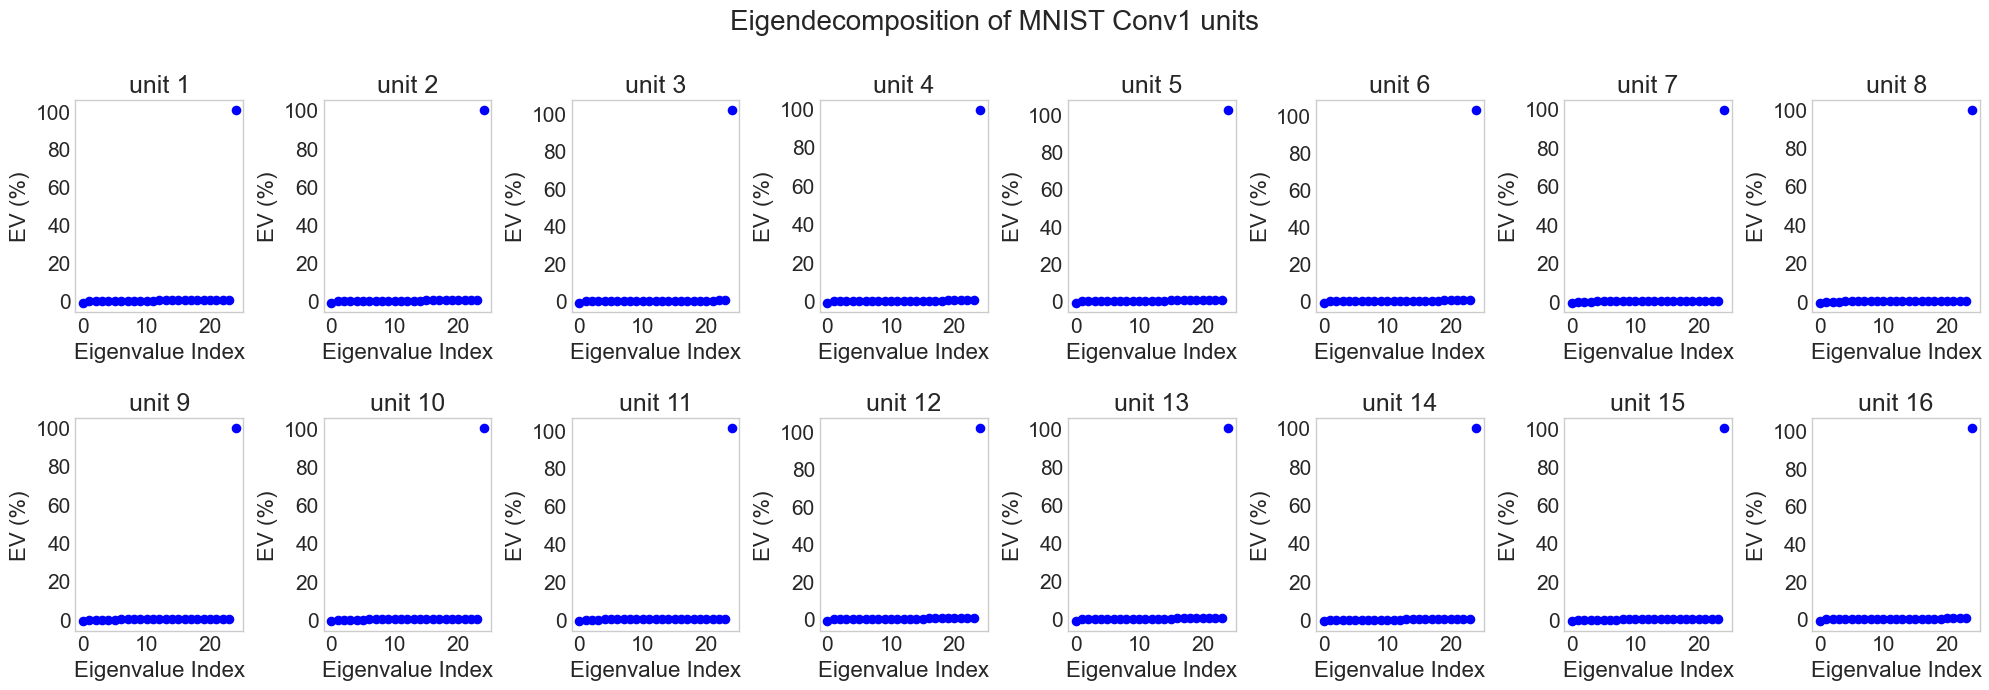

In [343]:
# visualise the eigenvalues
plt.style.use('seaborn-v0_8-whitegrid')
for i in range(cov1.shape[0]):
    plt.subplot(2, 8, i+1)
    y = eigenvalues1[i]
    # reverse the order of the eigenvalues
    y = -1*y.flip(0)
    y /= y.sum()
    y *= 100
    plt.scatter(range(len(eigenvalues1[i])), y, s=35, c='blue')
    plt.xlabel('Eigenvalue Index', fontsize=16)
    plt.ylabel('EV (%)', fontsize=16)
    plt.title('unit ' + str(i+1), fontsize=18)
    plt.gcf().set_size_inches(13, 5)
    # change axis font size
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    plt.grid(False)
    
plt.suptitle('Eigendecomposition of MNIST Conv1 units', fontsize=20) 
plt.gcf().set_size_inches(20, 7)
plt.tight_layout()
plt.subplots_adjust(top=0.85)
# add vertical space between subplots
plt.subplots_adjust(hspace=0.5)
plt.show()

-0.494 0.398


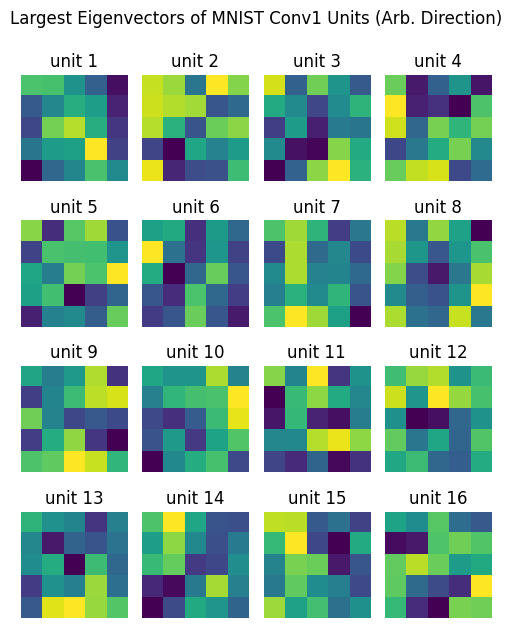

In [329]:
# Absolute = False - Visualise the RWA output as image plots
plt.style.use('default')
for i in range(rf1.shape[0]):
    plt.subplot(4, 4, i+1) # nrows, ncols, index
    plt.axis('off')
    x = eigenvectors1[i, :, 0].reshape(rf_cropped1.shape[1], rf_cropped1.shape[2], rf_cropped1.shape[3])
    to_show = (x - x.min()) / (x.max() - x.min())
    plt.imshow(to_show)
    plt.title(f'unit {str(i+1)}', fontsize=12)
    plt.gcf().set_size_inches(6, 6)
# title for the entire plot
plt.suptitle(f'Largest Eigenvectors of MNIST Conv1 Units (Arb. Direction)', fontsize=12)
print(np.round(float(rf_corr1.min()), 3), np.round(float(rf_corr1.max()), 3))
# change figure size
plt.gcf().set_size_inches(5, 6.5)
plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.show()

Grpahical Representation

In [233]:
noise_cropped_flat1 = noise_cropped1.view(noise_cropped1.shape[0], -1) # 50000, 8*8*3=192
rf_cropped_flat1 = rf_cropped1.view(rf_cropped1.shape[0], -1) # 16, 8*8*3=192

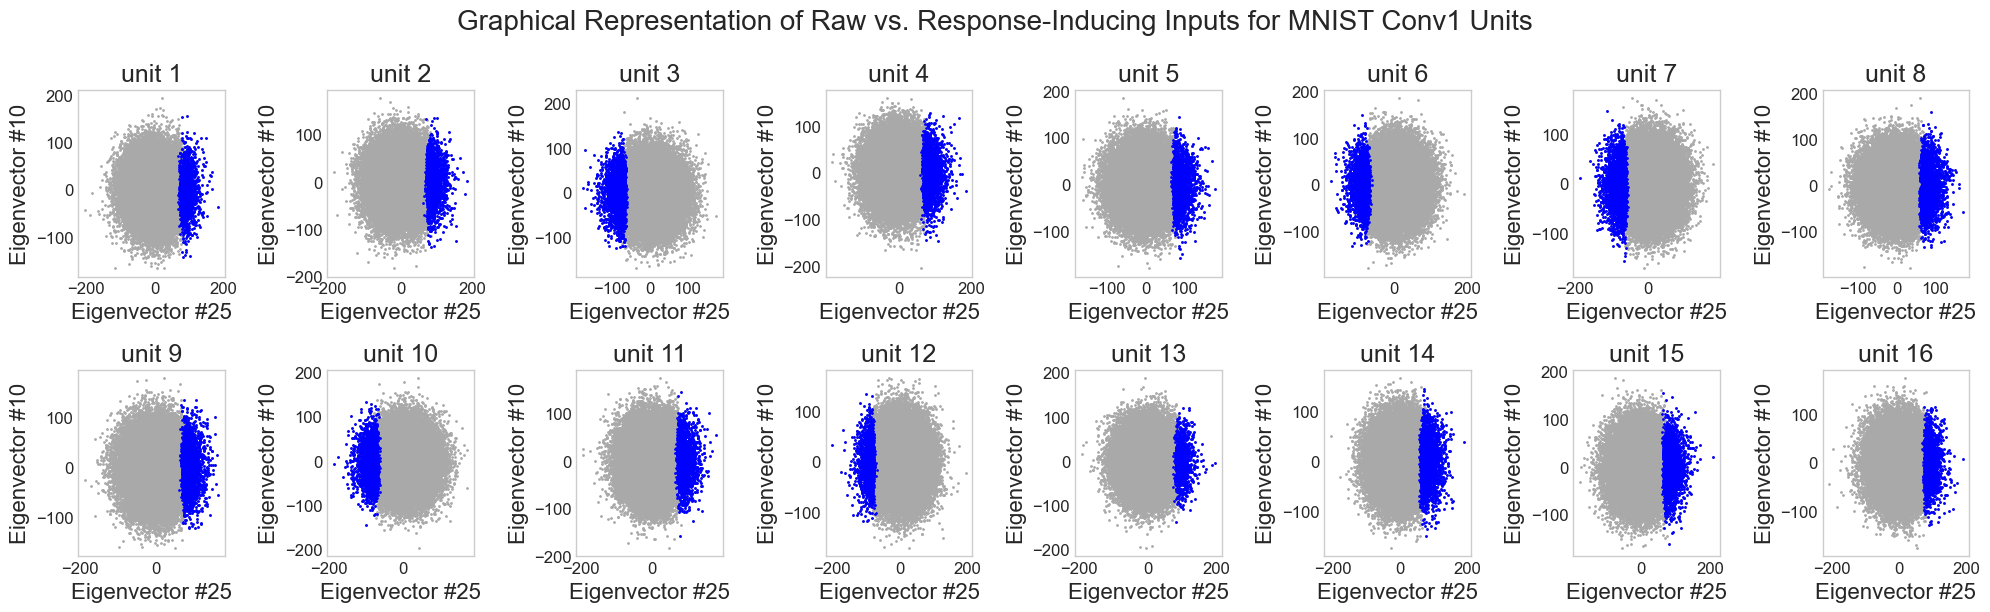

In [370]:
# PCA space
threshold = 50 # threshold for activation
plt.style.use('seaborn-v0_8-whitegrid')

for unit in range(cov1.shape[0]):
    plt.subplot(2, 8, unit+1)
    
    stixel1 = eigenvectors1[unit, :, 0] # max component for the unit
    stixel2 = eigenvectors1[unit, :, 10] # arbitrary component for the unit

    # Project noise onto the principal components
    proj1 = noise_cropped_flat1 @ stixel1
    proj2 = noise_cropped_flat1 @ stixel2

    # Plot the stixel 1 against stixel 2 for the noise inputs
    plt.scatter(proj1, proj2, s=1, c='darkgray')

    # Stimulating noise inputs
    stimulate_cropped_flat1 = torch.zeros(noise_cropped_flat1.shape) # store the response-stimulating noise inputs
    for i in range(noise_cropped_flat1.shape[0]):
        if act_conv1[unit][i] > threshold:
            stimulate_cropped_flat1[i] = noise_cropped_flat1[i]
    stimulate_cropped_flat1 = stimulate_cropped_flat1[~torch.all(stimulate_cropped_flat1 == 0, dim=1)] # Remove zero components

    # Project stimulating noise onto the principal components
    proj1 = stimulate_cropped_flat1 @ stixel1
    proj2 = stimulate_cropped_flat1 @ stixel2
    
    # turn off grid
    plt.grid(False)
    
    # PLotting
    # set x tick and y tick size
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.xlabel('Eigenvector #25', fontsize=16)
    plt.ylabel('Eigenvector #10', fontsize=16)
    plt.title(f'unit {unit+1}', fontsize=18)
    plt.scatter(proj1, proj2, s=1, c='blue')
    plt.gcf().set_size_inches(5, 5)

# specify spacing between subplots without using tight_layout
plt.suptitle(f'Graphical Representation of Raw vs. Response-Inducing Inputs for MNIST Conv1 Units', fontsize=20) 
plt.gcf().set_size_inches(20, 6.2)
plt.tight_layout()
plt.subplots_adjust(top=0.85)
plt.subplots_adjust(wspace=0.7, hspace=0.5)
plt.show()

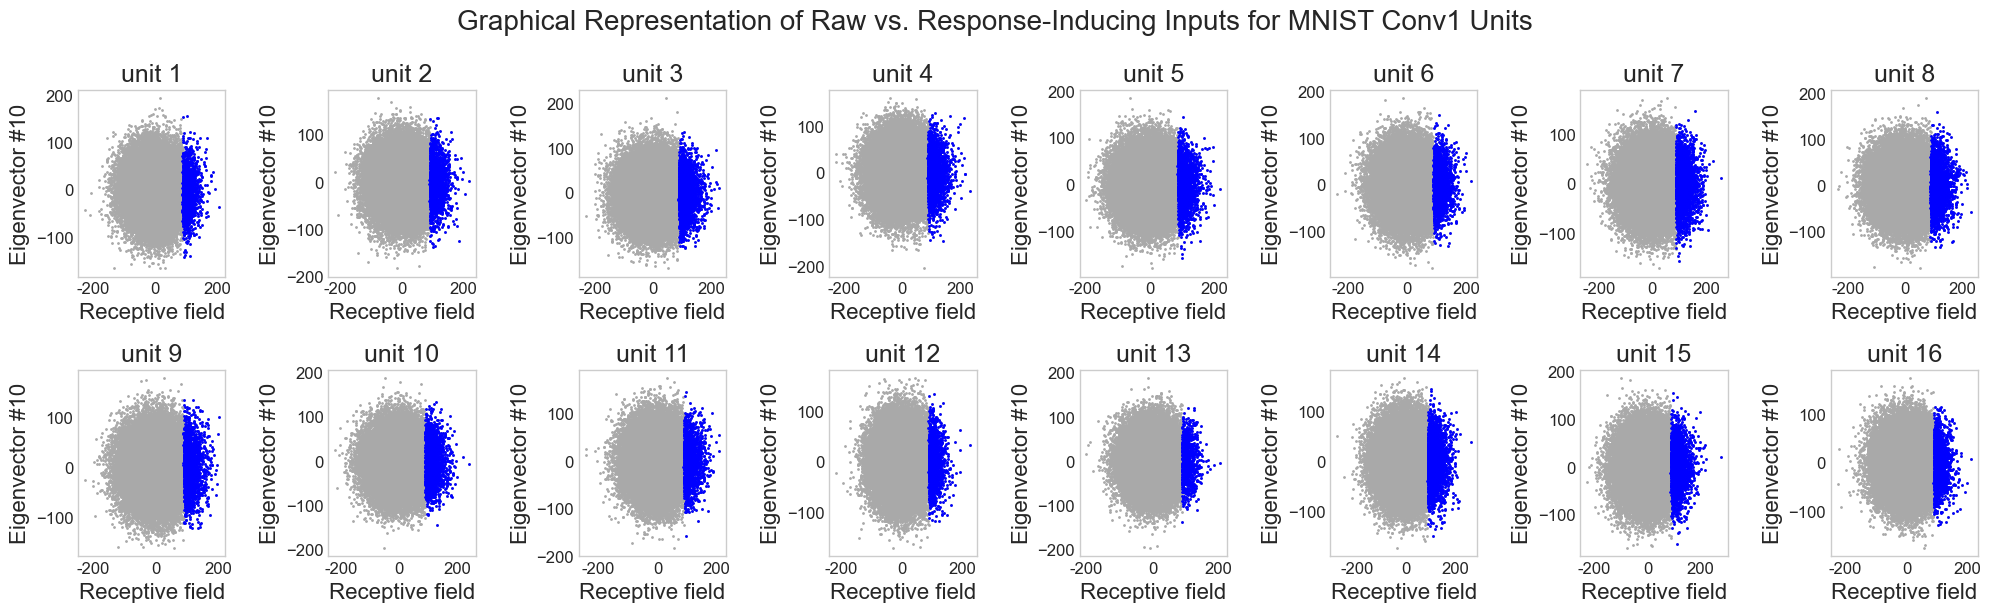

In [375]:
# RF space
threshold = 50 # threshold for activation
plt.style.use('seaborn-v0_8-whitegrid')

for unit in range(cov1.shape[0]):
    plt.subplot(2, 8, unit+1)
    
    stixel1 = rf_cropped_flat1[unit]
    stixel2 = eigenvectors1[unit, :, 10] # arbitrary component for the unit

    # Project noise onto the principal components
    proj1 = noise_cropped_flat1 @ stixel1
    proj2 = noise_cropped_flat1 @ stixel2

    # Plot the stixel 1 against stixel 2 for the noise inputs
    plt.scatter(proj1, proj2, s=1, c='darkgray')

    # Stimulating noise inputs
    stimulate_cropped_flat1 = torch.zeros(noise_cropped_flat1.shape) # store the response-stimulating noise inputs
    for i in range(noise_cropped_flat1.shape[0]):
        if act_conv1[unit][i] > threshold:
            stimulate_cropped_flat1[i] = noise_cropped_flat1[i]
    stimulate_cropped_flat1 = stimulate_cropped_flat1[~torch.all(stimulate_cropped_flat1 == 0, dim=1)] # Remove zero components

    # Project stimulating noise onto the principal components
    proj1 = stimulate_cropped_flat1 @ stixel1
    proj2 = stimulate_cropped_flat1 @ stixel2
    
    # turn off grid
    plt.grid(False)
    
    # PLotting
    # set x tick and y tick size
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.xlabel('Receptive field', fontsize=16)
    plt.ylabel('Eigenvector #10', fontsize=16)
    plt.title(f'unit {unit+1}', fontsize=18)
    plt.scatter(proj1, proj2, s=1, c='blue')
    plt.gcf().set_size_inches(5, 5)
    
    # divide x axis by 1000
    plt.gca().xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: int(x/1000)))

# specify spacing between subplots without using tight_layout
plt.suptitle(f'Graphical Representation of Raw vs. Response-Inducing Inputs for MNIST Conv1 Units', fontsize=20) 
plt.gcf().set_size_inches(20, 6.2)
plt.tight_layout()
plt.subplots_adjust(top=0.85)
plt.subplots_adjust(wspace=0.7, hspace=0.5)
plt.show()

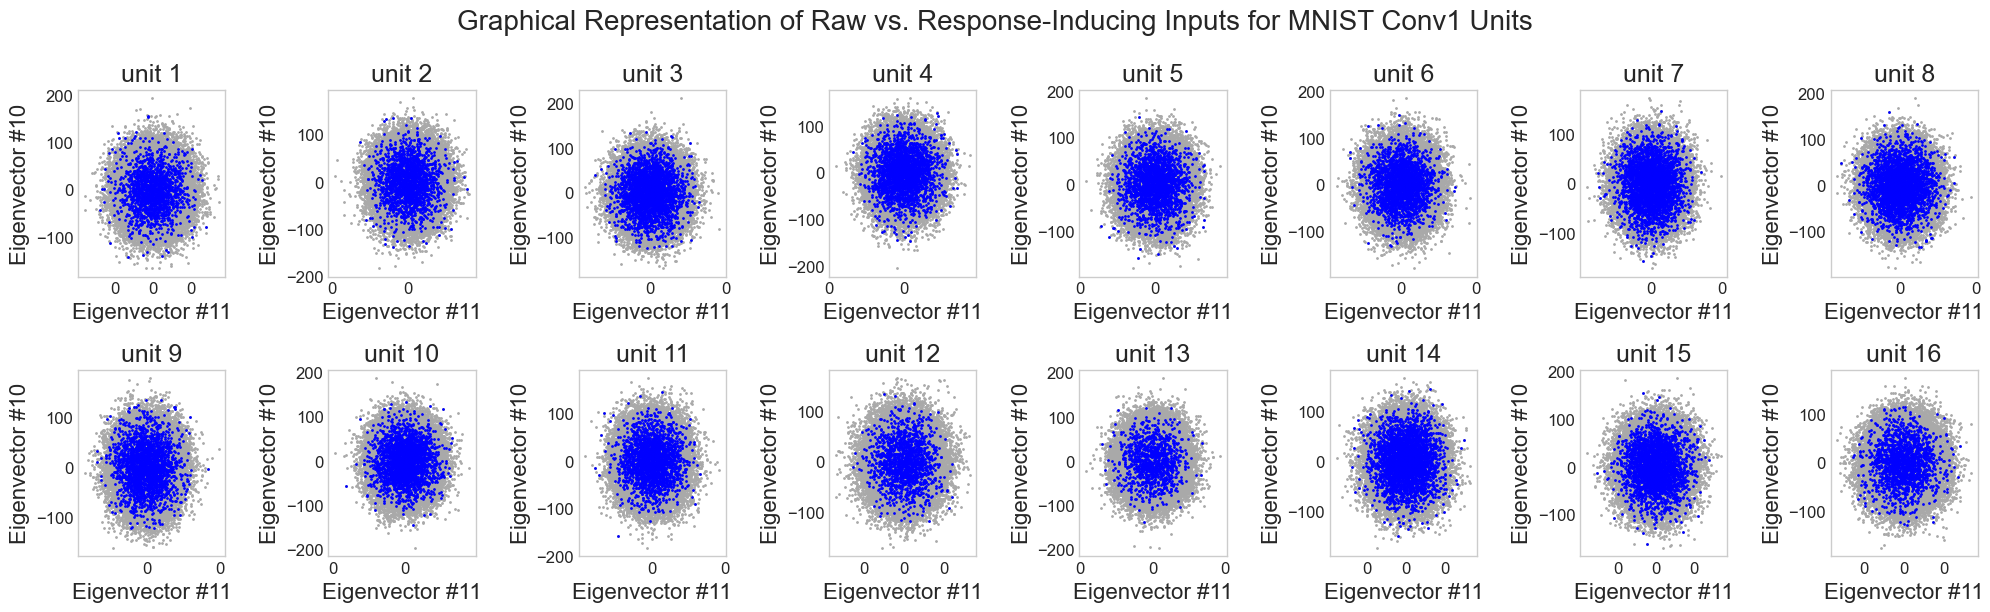

In [385]:
# RF space
threshold = 50 # threshold for activation
plt.style.use('seaborn-v0_8-whitegrid')

for unit in range(cov1.shape[0]):
    plt.subplot(2, 8, unit+1)
    
    stixel1 = eigenvectors1[unit, :, 11]
    stixel2 = eigenvectors1[unit, :, 10] # arbitrary component for the unit

    # Project noise onto the principal components
    proj1 = noise_cropped_flat1 @ stixel1
    proj2 = noise_cropped_flat1 @ stixel2

    # Plot the stixel 1 against stixel 2 for the noise inputs
    plt.scatter(proj1, proj2, s=1, c='darkgray')

    # Stimulating noise inputs
    stimulate_cropped_flat1 = torch.zeros(noise_cropped_flat1.shape) # store the response-stimulating noise inputs
    for i in range(noise_cropped_flat1.shape[0]):
        if act_conv1[unit][i] > threshold:
            stimulate_cropped_flat1[i] = noise_cropped_flat1[i]
    stimulate_cropped_flat1 = stimulate_cropped_flat1[~torch.all(stimulate_cropped_flat1 == 0, dim=1)] # Remove zero components

    # Project stimulating noise onto the principal components
    proj1 = stimulate_cropped_flat1 @ stixel1
    proj2 = stimulate_cropped_flat1 @ stixel2
    
    # turn off grid
    plt.grid(False)
    
    # PLotting
    # set x tick and y tick size
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.xlabel('Eigenvector #11', fontsize=16)
    plt.ylabel('Eigenvector #10', fontsize=16)
    plt.title(f'unit {unit+1}', fontsize=18)
    plt.scatter(proj1, proj2, s=1, c='blue')
    plt.gcf().set_size_inches(5, 5)
    
    # divide x axis by 1000
    plt.gca().xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: int(x/1000)))

# specify spacing between subplots without using tight_layout
plt.suptitle(f'Graphical Representation of Raw vs. Response-Inducing Inputs for MNIST Conv1 Units', fontsize=20) 
plt.gcf().set_size_inches(20, 6.2)
plt.tight_layout()
plt.subplots_adjust(top=0.85)
plt.subplots_adjust(wspace=0.7, hspace=0.5)
plt.show()

In [380]:
mi_cropped_flat1 = mi_cropped1.view(mi_cropped1.shape[0], -1)
mi_cropped_flat1.shape

torch.Size([16, 25])

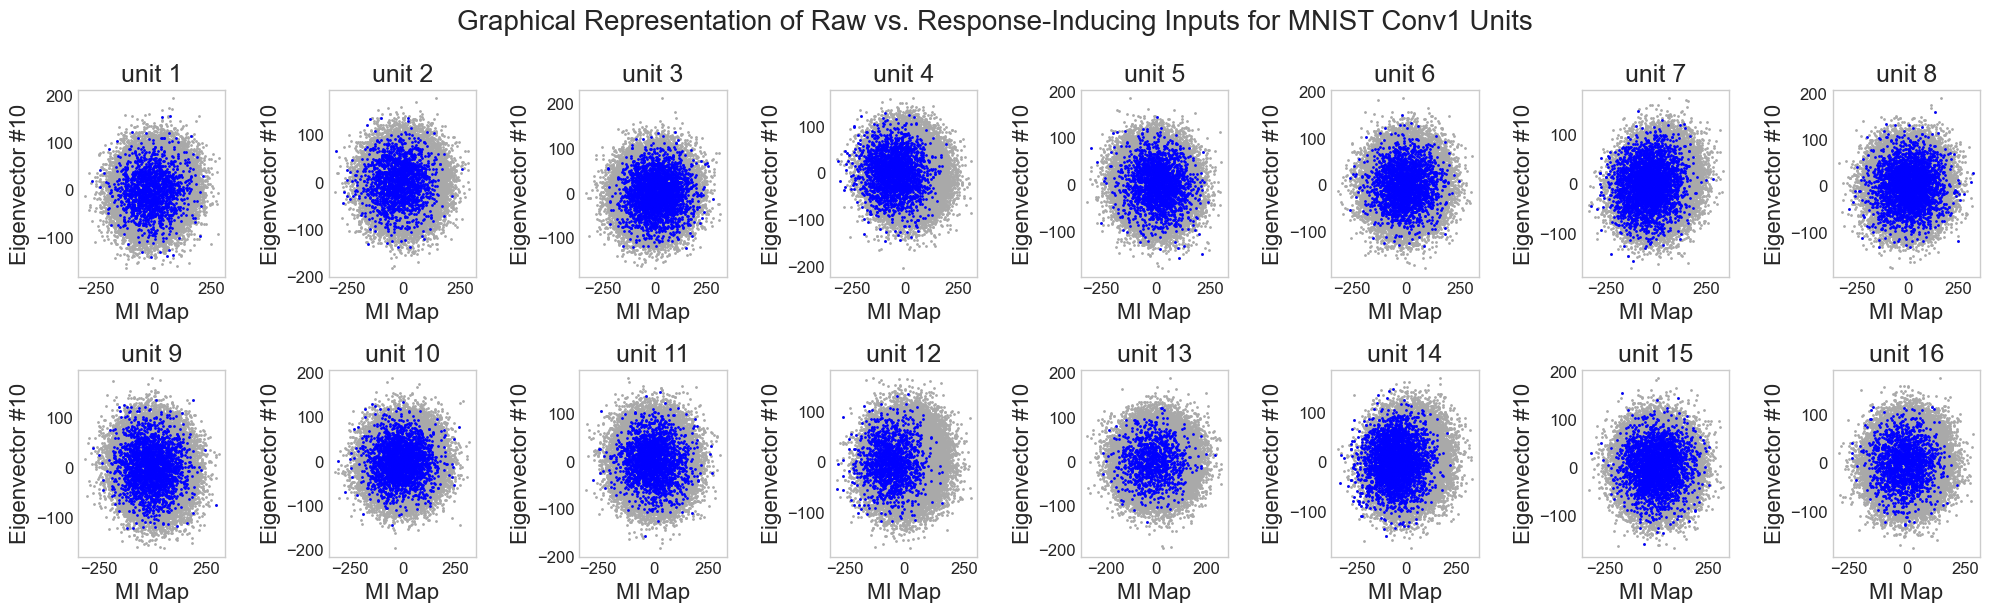

In [384]:
# RF space
threshold = 50 # threshold for activation
plt.style.use('seaborn-v0_8-whitegrid')

for unit in range(cov1.shape[0]):
    plt.subplot(2, 8, unit+1)
    
    stixel1 = mi_cropped_flat1[unit]
    stixel2 = eigenvectors1[unit, :, 10] # arbitrary component for the unit

    # Project noise onto the principal components
    proj1 = noise_cropped_flat1 @ stixel1
    proj2 = noise_cropped_flat1 @ stixel2

    # Plot the stixel 1 against stixel 2 for the noise inputs
    plt.scatter(proj1, proj2, s=1, c='darkgray')

    # Stimulating noise inputs
    stimulate_cropped_flat1 = torch.zeros(noise_cropped_flat1.shape) # store the response-stimulating noise inputs
    for i in range(noise_cropped_flat1.shape[0]):
        if act_conv1[unit][i] > threshold:
            stimulate_cropped_flat1[i] = noise_cropped_flat1[i]
    stimulate_cropped_flat1 = stimulate_cropped_flat1[~torch.all(stimulate_cropped_flat1 == 0, dim=1)] # Remove zero components

    # Project stimulating noise onto the principal components
    proj1 = stimulate_cropped_flat1 @ stixel1
    proj2 = stimulate_cropped_flat1 @ stixel2
    
    # turn off grid
    plt.grid(False)
    
    # PLotting
    # set x tick and y tick size
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.xlabel('MI Map', fontsize=16)
    plt.ylabel('Eigenvector #10', fontsize=16)
    plt.title(f'unit {unit+1}', fontsize=18)
    plt.scatter(proj1, proj2, s=1, c='blue')
    plt.gcf().set_size_inches(5, 5)

# specify spacing between subplots without using tight_layout
plt.suptitle(f'Graphical Representation of Raw vs. Response-Inducing Inputs for MNIST Conv1 Units', fontsize=20) 
plt.gcf().set_size_inches(20, 6.2)
plt.tight_layout()
plt.subplots_adjust(top=0.85)
plt.subplots_adjust(wspace=0.7, hspace=0.5)
plt.show()

Absolute RWA

In [386]:
# RWA
rf1 = RWA(act_conv1, noise1, absolute=True)
print(rf1.shape)

100%|██████████| 800000/800000 [00:30<00:00, 26647.47it/s]


Shape of receptive field list: torch.Size([16, 28, 28, 1])
torch.Size([16, 28, 28, 1])


-23.074 23.958


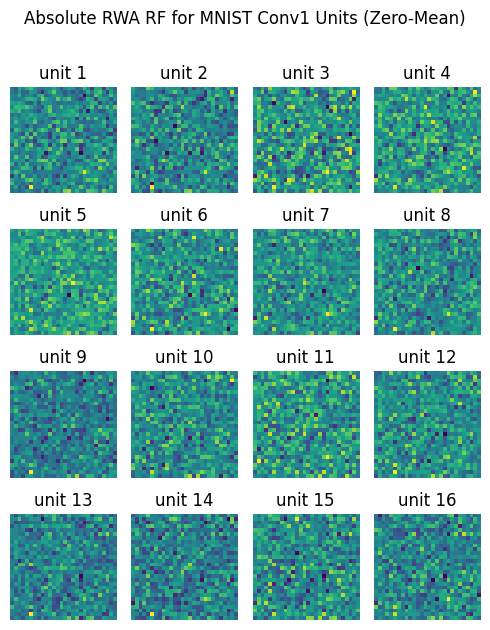

In [388]:
# Absolute = True - Visualise the RWA output as image plots
plt.style.use('default')
for i in range(rf1.shape[0]):
    plt.subplot(4, 4, i+1) # nrows, ncols, index
    plt.axis('off')
    to_show = rf1[i]
    
    # if the unit is not dead (positive activation values)
    if act_conv1[i][act_conv1[i] > 0].shape[0] != 0: # negative activation values are dead units
        to_show = (to_show - to_show.min()) / (to_show.max() - to_show.min()) # normalise to [0, 1]
        plt.imshow(to_show)
    else:
        # show a black image
        plt.imshow(np.zeros((rf1.shape[1], rf1.shape[2], rf1.shape[3])))
    plt.title(f'unit {str(i+1)}', fontsize=12)
    plt.gcf().set_size_inches(7, 7)
    
# title for the entire plot
plt.suptitle(f'Absolute RWA RF for MNIST Conv1 Units (Zero-Mean)', fontsize=12)
print(np.round(float(rf1.min()), 3), np.round(float(rf1.max()), 3))
# increase the spacing between subplots
# change figure size
plt.gcf().set_size_inches(5, 6.5)
plt.tight_layout()
plt.subplots_adjust(top=0.88)
plt.show()

# Conv1 - Positive Only [0, 255]

In [ ]:
# load existing data if already recorded
path_dict = {True: '_0mean', False:'', 'conv1': 1, 'conv2': 2}

batch_num = 100
batch_size = 500
zero_mean = False
layer = 'conv1'

act_conv1 = torch.load(f'./rwa_data/mnist/mnist_rand{path_dict[zero_mean]}/act{path_dict[layer]}.pt')
noise1 = torch.load(f'./rwa_data/mnist/mnist_rand{path_dict[zero_mean]}/noise{path_dict[layer]}.pt')

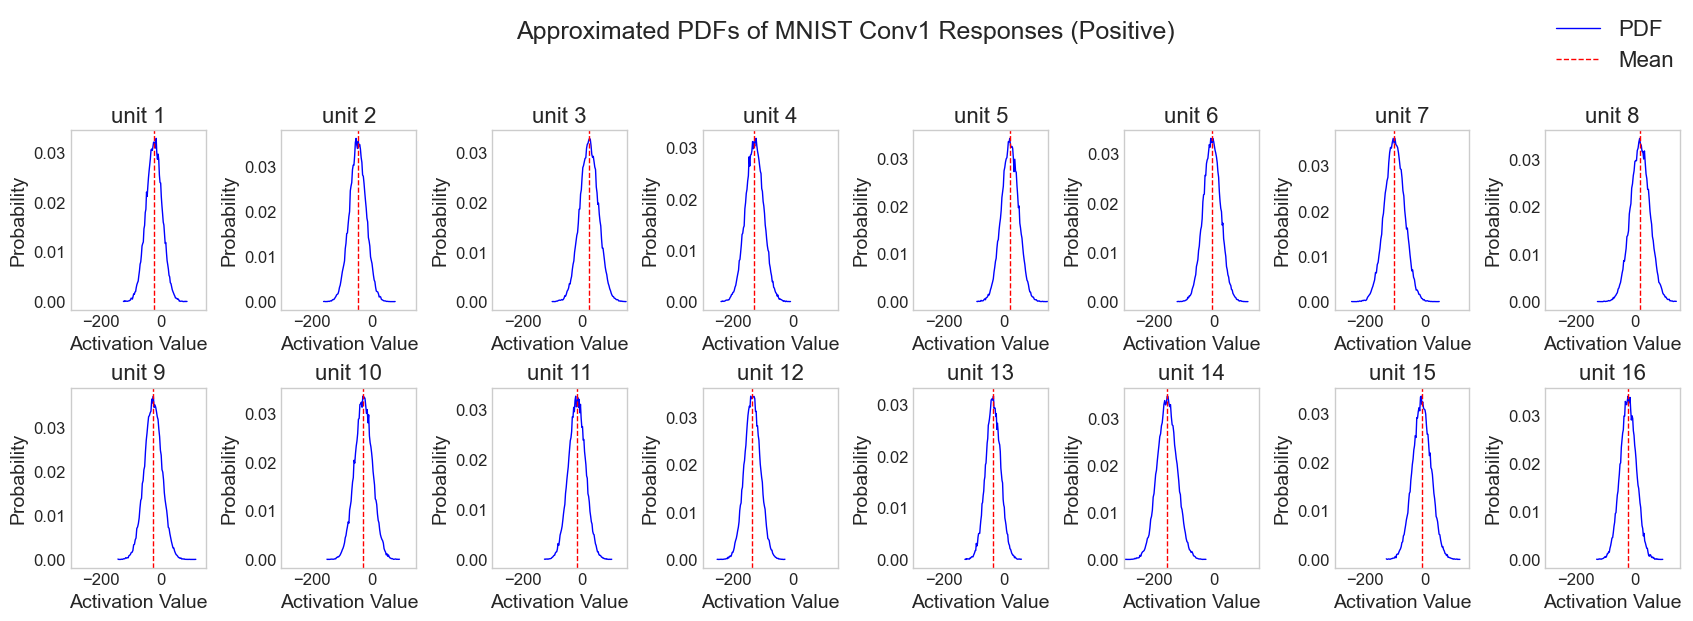

In [424]:
# PDFs of conv1 responses
# gaussian shape is a result of convolution
plt.style.use('seaborn-v0_8-whitegrid')
for i in range(act_conv1.shape[0]):
    plt.subplot(4, 8, i+1)
    plt.xlim(act_conv1.min(), act_conv1.max())
    
    if act_conv1[i][act_conv1[i] != 0].shape[0] != 0: # if unit is not dead
        counts, bin_edges = np.histogram(act_conv1[i], bins=100)
        pdf = counts / sum(counts) # normalise the counts to get the PDF
        bin_centers = (bin_edges[1:] + bin_edges[:-1]) / 2
        plt.plot(bin_centers, pdf, color='blue', linewidth=1)
        plt.xlabel('Activation Value', fontsize=14)
        plt.ylabel('Probability', fontsize=14)
        plt.axvline(act_conv1[i].mean(), color='red', linestyle='dashed', linewidth=1)
        plt.title('unit ' + str(i+1), fontsize=16)
    else:
        # plot shows text saying 'inactive'
        plt.text(0.5, 0.5, 'inactive', horizontalalignment='center', verticalalignment='center')
        plt.title('unit ' + str(i+1), fontsize=16)
        plt.axis('off')
    plt.gcf().set_size_inches(14, 9)
    
    # turn off gird
    plt.grid(False)
    # set xtick and ytick size
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)

plt.suptitle('Approximated PDFs of MNIST Conv1 Responses (Positive)', fontsize=18)

# add a legend
plt.figlegend(['PDF', 'Mean'], loc='upper right', fontsize=16)

# add a boundary box to the legend
# change figure size
plt.gcf().set_size_inches(17, 11)
plt.tight_layout()

# add space below the title
plt.subplots_adjust(top=0.88)
plt.show()

RWA

In [402]:
# RWA - unbiased RF estimation, absolute false
rf1 = RWA(act_conv1, noise1, absolute=False)
print(rf1.shape)

100%|██████████| 800000/800000 [00:25<00:00, 30963.82it/s]

Shape of receptive field list: torch.Size([16, 28, 28, 1])
torch.Size([16, 28, 28, 1])


In [403]:
# Save the RWA data
torch.save(rf1, f'./rwa_data/mnist/mnist_rand{path_dict[zero_mean]}/rf{path_dict[layer]}.pt')

-20534.877 3390.531


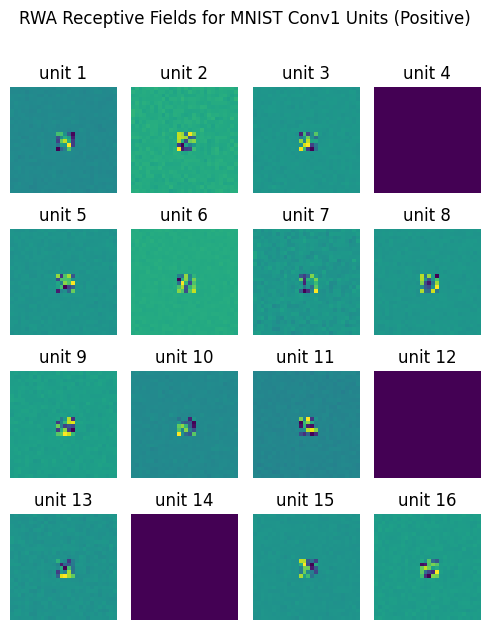

In [425]:
# Absolute = False - Visualise the RWA output as image plots
plt.style.use('default')
for i in range(rf1.shape[0]):
    plt.subplot(4, 4, i+1) # nrows, ncols, index
    plt.axis('off')
    to_show = rf1[i]
    
    # if the unit is not dead (positive activation values)
    if act_conv1[i][act_conv1[i] > 0].shape[0] != 0: # negative activation values are dead units
        to_show = (to_show - to_show.min()) / (to_show.max() - to_show.min()) # normalise to [0, 1]
        plt.imshow(to_show)
    else:
        # show a black image
        plt.imshow(np.zeros((rf1.shape[1], rf1.shape[2], rf1.shape[3])))
    plt.title(f'unit {str(i+1)}', fontsize=12)
    plt.gcf().set_size_inches(7, 7)
    
# title for the entire plot
plt.suptitle(f'RWA Receptive Fields for MNIST Conv1 Units (Positive)', fontsize=12)
print(np.round(float(rf1.min()), 3), np.round(float(rf1.max()), 3))
# increase the spacing between subplots
# change figure size
plt.gcf().set_size_inches(5, 6.5)
plt.tight_layout()
plt.subplots_adjust(top=0.88)
plt.show()

Receptive Field Estimation via Pearson Correlation

In [405]:
# Absolute = false - gets the correlation between the RF and the noise for each unit
rf_corr1 = torch.zeros(rf1.shape)
for i in range(rf1.shape[3]): # loop through each channel
    rf_corr1[:, :, :, i] = CorrRWA(act_conv1, noise1[:, :, :, i])

100%|██████████| 12544/12544 [00:26<00:00, 481.20it/s]


In [406]:
# Save the RWA data
torch.save(rf_corr1, f'./rwa_data/mnist/mnist_rand{path_dict[zero_mean]}/rf_corr{path_dict[layer]}.pt')

-0.494 0.406


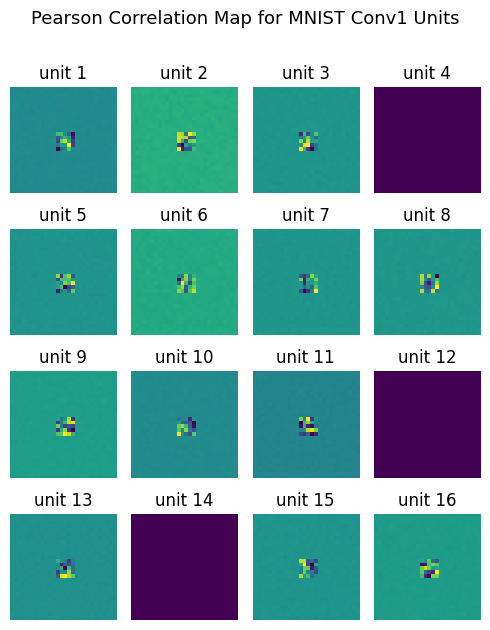

In [407]:
# Absolute = False - Visualise the RWA output as image plots
for i in range(rf1.shape[0]):
    plt.subplot(4, 4, i+1) # nrows, ncols, index
    plt.axis('off')
    to_show = rf_corr1[i]
    
    # if the unit is not dead (positive activation values)
    if act_conv1[i][act_conv1[i] > 0].shape[0] != 0: # negative activation values are dead units
        to_show = (to_show - to_show.min()) / (to_show.max() - to_show.min()) # normalise to [0, 1]
        plt.imshow(to_show)
    else:
        # show a black image
        plt.imshow(np.zeros((rf1.shape[1], rf1.shape[2], rf1.shape[3])))
    plt.title(f'unit {str(i+1)}', fontsize=12)
    plt.gcf().set_size_inches(7, 7)
    
# title for the entire plot
plt.suptitle(f'Pearson Correlation Map for MNIST Conv1 Units', fontsize=13)
print(np.round(float(rf_corr1.min()), 3), np.round(float(rf_corr1.max()), 3))
# change figure size
plt.gcf().set_size_inches(5, 6.5)
plt.tight_layout()
plt.subplots_adjust(top=0.88)
plt.show()

In [408]:
# crop the RFs
# Threshold for cropping automatically set at 0.01
rf_cropped1 = []
for i in range(rf1.shape[3]): # loop through each channel
    tmp, mask = RfCrop(correlation1[:, :, i], rf1[:, :, :, i]) # crop the RFs
    rf_cropped1.append(tmp)
rf_cropped1 = torch.stack(rf_cropped1, dim=3)

-0.494 0.406


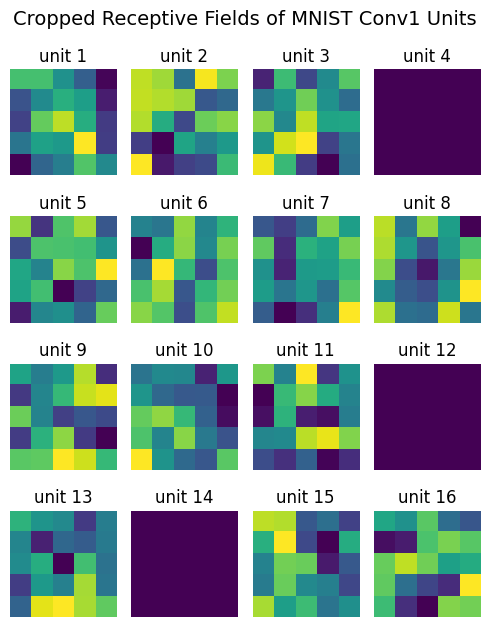

In [409]:
# Absolute = False - Visualise the RWA output as image plots
for i in range(rf1.shape[0]):
    plt.subplot(4, 4, i+1) # nrows, ncols, index
    plt.axis('off')
    to_show = rf_cropped1[i]
    
    # if the unit is not dead (positive activation values)
    if act_conv1[i][act_conv1[i] > 0].shape[0] != 0: # negative activation values are dead units
        to_show = (to_show - to_show.min()) / (to_show.max() - to_show.min()) # normalise to [0, 1]
        plt.imshow(to_show)
    else:
        # show a black image
        plt.imshow(np.zeros((rf1.shape[1], rf1.shape[2], rf1.shape[3])))
    plt.title(f'unit {str(i+1)}', fontsize=12)
    plt.gcf().set_size_inches(6, 6)
    
# title for the entire plot
plt.suptitle(f'Cropped Receptive Fields of MNIST Conv1 Units', fontsize=14)
print(np.round(float(rf_corr1.min()), 3), np.round(float(rf_corr1.max()), 3))
# change figure size
plt.gcf().set_size_inches(5, 6.5)
plt.tight_layout()
plt.show()

In [410]:
# round every number in noise1 to nearest whole number
noise1_ = np.round(noise1)
act_conv1_ = np.round(act_conv1)

In [411]:
num_units = act_conv1.shape[0]
mi1 = torch.zeros((num_units, noise1.shape[1], noise1.shape[2])) # single channel

with tqdm(total = num_units * noise1.shape[1] * noise1.shape[2]) as pbar:
    for i in range(num_units):
        for j in range(noise1.shape[1]):
            for k in range(noise1.shape[2]): # go through each pixel
                mi1[i, j, k] = mutual_info_score(noise1_[:, j, k].flatten(), act_conv1_[i].flatten())
                pbar.update(1)

100%|██████████| 12544/12544 [05:14<00:00, 39.87it/s]


In [412]:
# save the cropped RFs
torch.save(mi1, f'./rwa_data/mnist/mnist_rand{path_dict[zero_mean]}/mi{path_dict[layer]}.pt')

-0.494 0.406


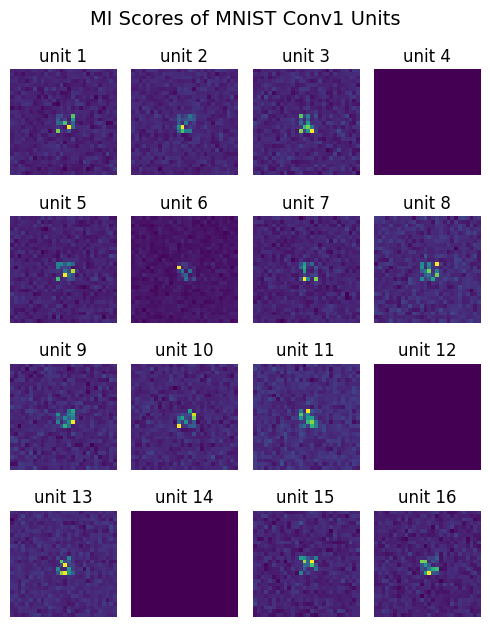

In [413]:
# Absolute = False - Visualise the RWA output as image plots
for i in range(rf1.shape[0]):
    plt.subplot(4, 4, i+1) # nrows, ncols, index
    plt.axis('off')
    to_show = mi1[i]
    
    # if the unit is not dead (positive activation values)
    if act_conv1[i][act_conv1[i] > 0].shape[0] != 0: # negative activation values are dead units
        to_show = (to_show - to_show.min()) / (to_show.max() - to_show.min()) # normalise to [0, 1]
        plt.imshow(to_show)
    else:
        # show a black image
        plt.imshow(np.zeros((rf1.shape[1], rf1.shape[2], rf1.shape[3])))
    plt.title(f'unit {str(i+1)}', fontsize=12)
    plt.gcf().set_size_inches(6, 6)
    
# title for the entire plot
plt.suptitle(f'MI Scores of MNIST Conv1 Units', fontsize=14)
print(np.round(float(rf_corr1.min()), 3), np.round(float(rf_corr1.max()), 3))
# change figure size
plt.gcf().set_size_inches(5, 6.5)
plt.tight_layout()
plt.show()

In [414]:
# crop the RFs
# Threshold for cropping automatically set at 0.01
mi_cropped1, _ = RfCrop(correlation1[:, :, 0], mi1[:, :, :]) # crop the RFs

-0.494 0.406


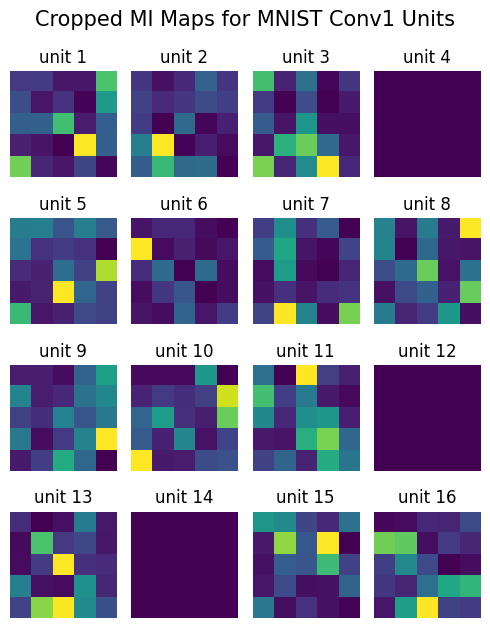

In [415]:
# Absolute = False - Visualise the RWA output as image plots
for i in range(rf1.shape[0]):
    plt.subplot(4, 4, i+1) # nrows, ncols, index
    plt.axis('off')
    to_show = mi_cropped1[i]
    
    # if the unit is not dead (positive activation values)
    if act_conv1[i][act_conv1[i] > 0].shape[0] != 0: # negative activation values are dead units
        to_show = (to_show - to_show.min()) / (to_show.max() - to_show.min()) # normalise to [0, 1]
        plt.imshow(to_show)
    else:
        # show a black image
        plt.imshow(np.zeros((rf1.shape[1], rf1.shape[2], rf1.shape[3])))
    plt.title(f'unit {str(i+1)}', fontsize=12)
    plt.gcf().set_size_inches(6, 6)
    
# title for the entire plot
plt.suptitle(f'Cropped MI Maps for MNIST Conv1 Units', fontsize=15)
print(np.round(float(rf_corr1.min()), 3), np.round(float(rf_corr1.max()), 3))
# change figure size
plt.gcf().set_size_inches(5, 6.5)
plt.tight_layout()
plt.show()

Response-Weighted Covariance - Normal RWA

In [416]:
# crop noise to the same dimensions as the cropped RFs
noise_cropped1 = torch.zeros(noise1.shape[0], rf_cropped1.shape[1], rf_cropped1.shape[2], rf_cropped1.shape[3])
for i in range(noise_cropped1.shape[3]):
    tmp, _ = RfCrop(correlation1[:, :, i], noise1[:, :, :, i])
    noise_cropped1[:, :, :, i] = tmp
print(noise_cropped1.shape)

torch.Size([50000, 5, 5, 1])


In [417]:
torch.save(noise_cropped1, f'./rwa_data/mnist/mnist_rand{path_dict[zero_mean]}/noise_cropped{path_dict[layer]}.pt')

In [418]:
# unravel noise and RFs for RWC + create input for RWC
noise_cropped_flat1 = noise_cropped1.view(noise_cropped1.shape[0], -1) # 50000, 8*8*3=192
rf_cropped_flat1 = rf_cropped1.view(rf_cropped1.shape[0], -1) # 16, 8*8*3=192

# reformat magnitudes of rf data to fit with noise
if zero_mean:
    rf = ((rf_cropped_flat1 - rf_cropped_flat1.min()) / (rf_cropped_flat1.max() - rf_cropped_flat1.min()) - 0.5) * 255 # normalise to [-127.5, 127.5]
else:
    rf = (rf_cropped_flat1 - rf_cropped_flat1.min()) / (rf_cropped_flat1.max() - rf_cropped_flat1.min()) * 255 # normalise to [0, 255]
    
# compute input data for RWC
# mu = noise - rf
mu = torch.zeros(rf_cropped_flat1.shape[0], noise_cropped_flat1.shape[0], noise_cropped_flat1.shape[1])
for i in range(mu.shape[0]):
    mu[i] = noise_cropped_flat1 - rf[i]

# RWC
cov1 = RWC(act_conv1, mu)

100%|██████████| 800000/800000 [00:23<00:00, 33459.22it/s]


In [419]:
# save the pca covariance data
torch.save(cov1, f'./rwa_data/mnist/mnist_rand{path_dict[zero_mean]}/cov{path_dict[layer]}.pt')

In [441]:
# Principal Component Analysis
eigenvalues1 = torch.zeros(cov1.shape[0], cov1.shape[1])
eigenvectors1 = torch.zeros((cov1.shape[0], cov1.shape[1], cov1.shape[1])) # store the PCA components

# Get relevant results
for i in range(cov1.shape[0]): # loop through each unit
    eigen = np.linalg.eigh(cov1[i])
    eigenvectors1[i] = torch.tensor(eigen.eigenvectors)
    eigenvalues1[i] = torch.tensor(eigen.eigenvalues)

In [442]:
# Store the eigenvalues and eigenvectors
eigen1 = (eigenvectors1, eigenvalues1)
with open(f'./rwa_data/mnist/mnist_rand{path_dict[zero_mean]}/eigen{path_dict[layer]}.pkl', 'wb') as f:
    pickle.dump(eigen1, f)

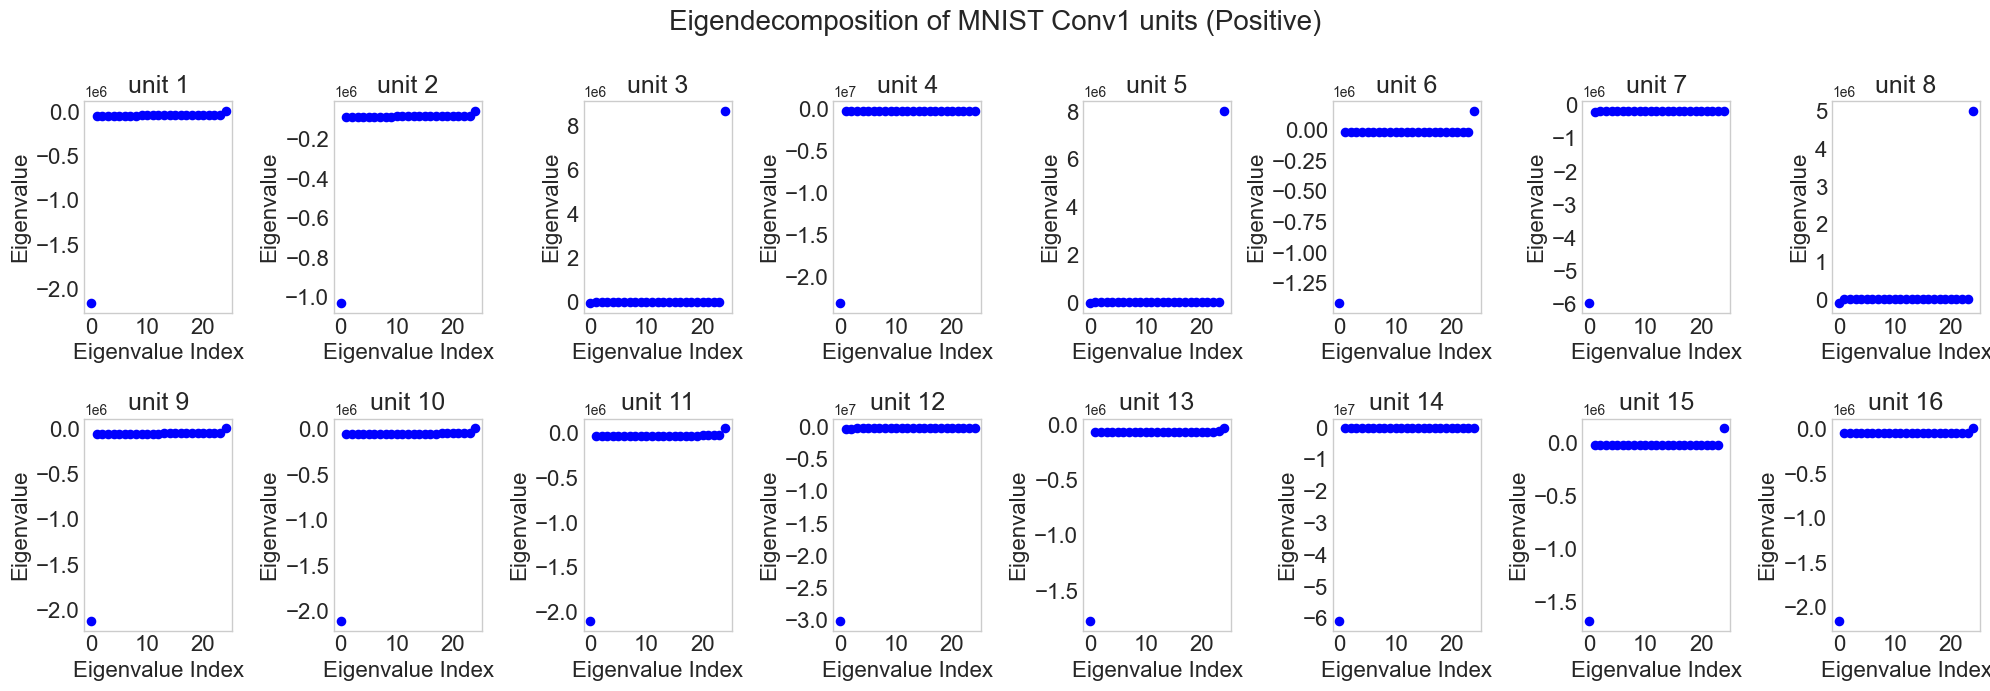

In [444]:
# visualise the eigenvalues
plt.style.use('seaborn-v0_8-whitegrid')
for i in range(cov1.shape[0]):
    plt.subplot(2, 8, i+1)
    plt.scatter(range(len(eigenvalues1[i])), eigenvalues1[i], s=35, c='blue')
    plt.xlabel('Eigenvalue Index', fontsize=16)
    plt.ylabel('Eigenvalue', fontsize=16)
    plt.title('unit ' + str(i+1), fontsize=18)
    plt.gcf().set_size_inches(13, 5)
    # change axis font size
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    plt.grid(False)
    
plt.suptitle('Eigendecomposition of MNIST Conv1 units (Positive)', fontsize=20) 
plt.gcf().set_size_inches(20, 7)
plt.tight_layout()
plt.subplots_adjust(top=0.85)
# add vertical space between subplots
plt.subplots_adjust(hspace=0.5)
plt.show()

-0.494 0.406


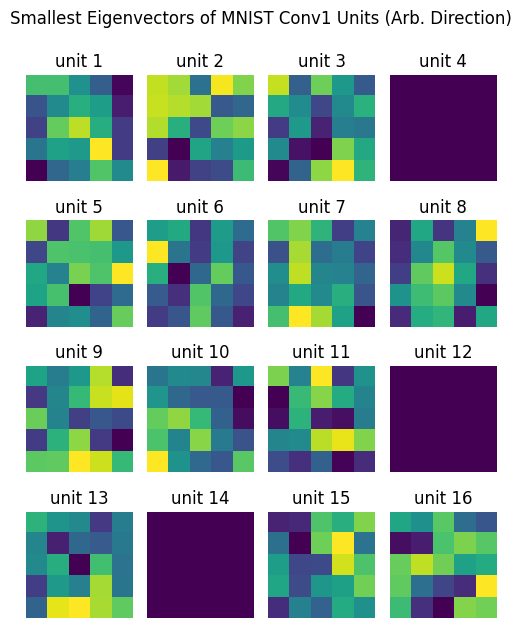

In [446]:
# Absolute = False - Visualise the RWA output as image plots
plt.style.use('default')
for i in range(rf1.shape[0]):
    plt.subplot(4, 4, i+1) # nrows, ncols, index
    plt.axis('off')
    if act_conv1[i][act_conv1[i] > 0].shape[0] != 0: # negative activation values are dead units
        x = eigenvectors1[i, :, 0].reshape(rf_cropped1.shape[1], rf_cropped1.shape[2], rf_cropped1.shape[3])
        to_show = (x - x.min()) / (x.max() - x.min())
        plt.imshow(to_show)
    else:
        plt.imshow(np.zeros((rf1.shape[1], rf1.shape[2], rf1.shape[3])))
    plt.title(f'unit {str(i+1)}', fontsize=12)
    plt.gcf().set_size_inches(6, 6)
# title for the entire plot
plt.suptitle(f'Smallest Eigenvectors of MNIST Conv1 Units (Arb. Direction)', fontsize=12)
print(np.round(float(rf_corr1.min()), 3), np.round(float(rf_corr1.max()), 3))
# change figure size
plt.gcf().set_size_inches(5, 6.5)
plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.show()

-0.494 0.406


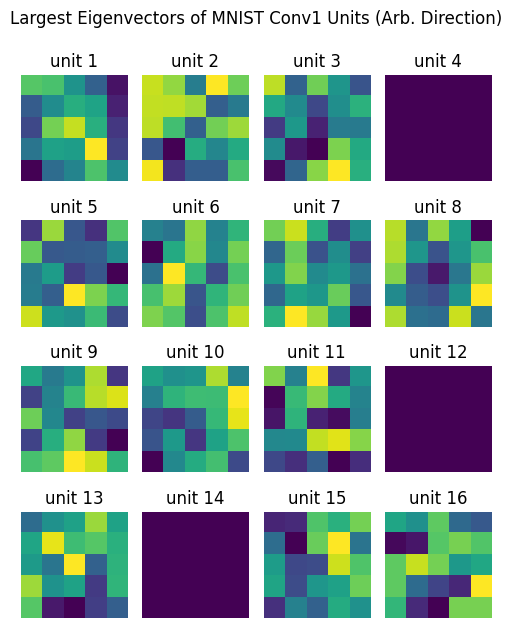

In [447]:
# Absolute = False - Visualise the RWA output as image plots
plt.style.use('default')
for i in range(rf1.shape[0]):
    plt.subplot(4, 4, i+1) # nrows, ncols, index
    plt.axis('off')
    if act_conv1[i][act_conv1[i] > 0].shape[0] != 0: # negative activation values are dead units
        x = eigenvectors1[i, :, -1].reshape(rf_cropped1.shape[1], rf_cropped1.shape[2], rf_cropped1.shape[3])
        to_show = (x - x.min()) / (x.max() - x.min())
        plt.imshow(to_show)
    else:
        plt.imshow(np.zeros((rf1.shape[1], rf1.shape[2], rf1.shape[3])))
    plt.title(f'unit {str(i+1)}', fontsize=12)
    plt.gcf().set_size_inches(6, 6)
# title for the entire plot
plt.suptitle(f'Largest Eigenvectors of MNIST Conv1 Units (Arb. Direction)', fontsize=12)
print(np.round(float(rf_corr1.min()), 3), np.round(float(rf_corr1.max()), 3))
# change figure size
plt.gcf().set_size_inches(5, 6.5)
plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.show()

Grpahical Representation

# Conv2 - Positive Only [0, 255]

In [ ]:
# load existing data if already recorded
path_dict = {True: '_0mean', False:'', 'conv1': 1, 'conv2': 2}

batch_num = 100
batch_size = 500
zero_mean = False
layer = 'conv2'

act_conv2 = torch.load(f'./rwa_data/mnist/mnist_rand{path_dict[zero_mean]}/act{path_dict[layer]}.pt')
noise2 = torch.load(f'./rwa_data/mnist/mnist_rand{path_dict[zero_mean]}/noise{path_dict[layer]}.pt')

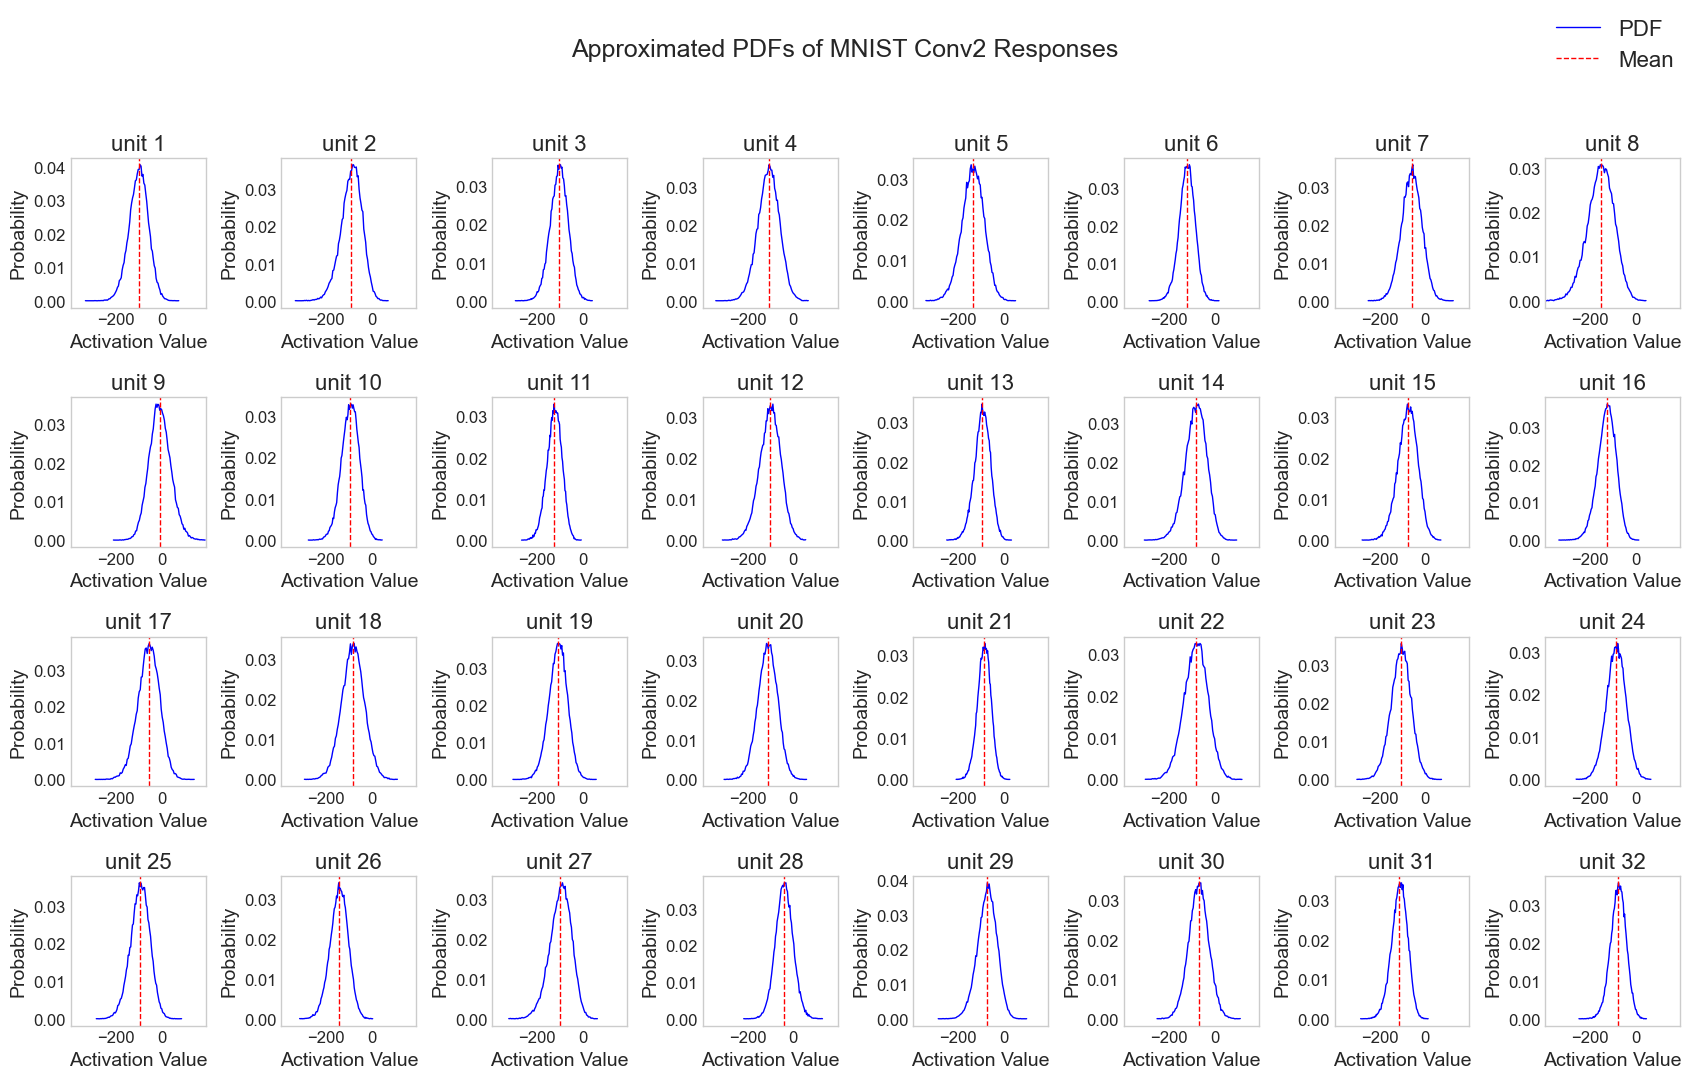

In [519]:
# PDFs of conv1 responses
# gaussian shape is a result of convolution
plt.style.use('seaborn-v0_8-whitegrid')
for i in range(act_conv2.shape[0]):
    plt.subplot(8, 8, i+1)
    plt.xlim(act_conv2.min(), act_conv2.max())
    
    if act_conv2[i][act_conv2[i] != 0].shape[0] != 0: # if unit is not dead
        counts, bin_edges = np.histogram(act_conv2[i], bins=100)
        pdf = counts / sum(counts) # normalise the counts to get the PDF
        bin_centers = (bin_edges[1:] + bin_edges[:-1]) / 2
        plt.plot(bin_centers, pdf, color='blue', linewidth=1)
        plt.xlabel('Activation Value', fontsize=14)
        plt.ylabel('Probability', fontsize=14)
        plt.axvline(act_conv2[i].mean(), color='red', linestyle='dashed', linewidth=1)
        plt.title('unit ' + str(i+1), fontsize=16)
    else:
        # plot shows text saying 'inactive'
        plt.text(0.5, 0.5, 'inactive', horizontalalignment='center', verticalalignment='center')
        plt.title('unit ' + str(i+1), fontsize=16)
        plt.axis('off')
    plt.gcf().set_size_inches(14, 17)
    
    # turn off gird
    plt.grid(False)
    # set xtick and ytick size
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)

plt.suptitle('Approximated PDFs of MNIST Conv2 Responses', fontsize=18)

# add a legend
plt.figlegend(['PDF', 'Mean'], loc='upper right', fontsize=16)

# add a boundary box to the legend
# change figure size
plt.gcf().set_size_inches(17, 20)
plt.tight_layout()

# add space below the title
plt.subplots_adjust(top=0.92)
plt.subplots_adjust(hspace=0.6)
plt.show()

RWA

In [463]:
# RWA - unbiased RF estimation, absolute false
rf2 = RWA(act_conv2, noise2, absolute=False)
print(rf2.shape)

100%|██████████| 1600000/1600000 [00:27<00:00, 57991.26it/s]

Shape of receptive field list: torch.Size([32, 28, 28, 1])
torch.Size([32, 28, 28, 1])


In [464]:
# Save the RWA data
torch.save(rf2, f'./rwa_data/mnist/mnist_rand{path_dict[zero_mean]}/rf{path_dict[layer]}.pt')

-16727.779 -2201.839


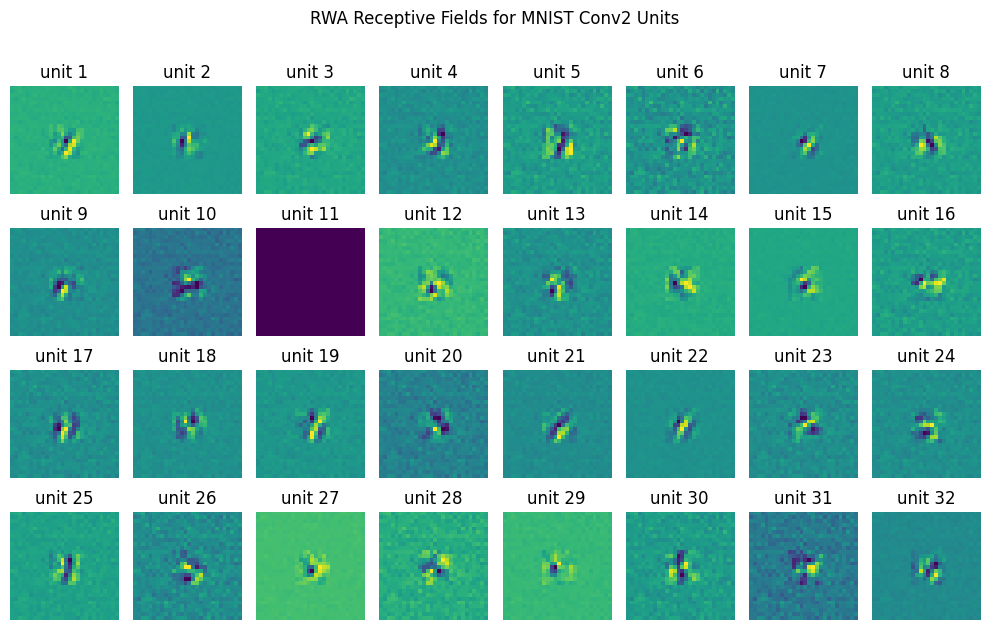

In [520]:
# Absolute = False - Visualise the RWA output as image plots
plt.style.use('default')
for i in range(rf2.shape[0]):
    plt.subplot(4, 8, i+1) # nrows, ncols, index
    plt.axis('off')
    to_show = rf2[i]
    
    # if the unit is not dead (positive activation values)
    if act_conv2[i][act_conv2[i] > 0].shape[0] != 0: # negative activation values are dead units
        to_show = (to_show - to_show.min()) / (to_show.max() - to_show.min()) # normalise to [0, 1]
        plt.imshow(to_show)
    else:
        # show a black image
        plt.imshow(np.zeros((rf2.shape[1], rf2.shape[2], rf2.shape[3])))
    plt.title(f'unit {str(i+1)}', fontsize=12)
    plt.gcf().set_size_inches(7, 7)
    
# title for the entire plot
plt.suptitle(f'RWA Receptive Fields for MNIST Conv2 Units', fontsize=12)
print(np.round(float(rf2.min()), 3), np.round(float(rf2.max()), 3))
# increase the spacing between subplots
# change figure size
plt.gcf().set_size_inches(10, 6.5)
plt.tight_layout()
plt.subplots_adjust(top=0.88)
plt.show()

Receptive Field Estimation via Pearson Correlation

In [469]:
# Absolute = false - gets the correlation between the RF and the noise for each unit
rf_corr2 = torch.zeros(rf2.shape)
for i in range(rf2.shape[3]): # loop through each channel
    rf_corr2[:, :, :, i] = CorrRWA(act_conv2, noise2[:, :, :, i])

100%|██████████| 25088/25088 [00:26<00:00, 932.15it/s] 


In [470]:
# Save the RWA data
torch.save(rf_corr2, f'./rwa_data/mnist/mnist_rand{path_dict[zero_mean]}/rf_corr{path_dict[layer]}.pt')

-16727.779 -2201.839


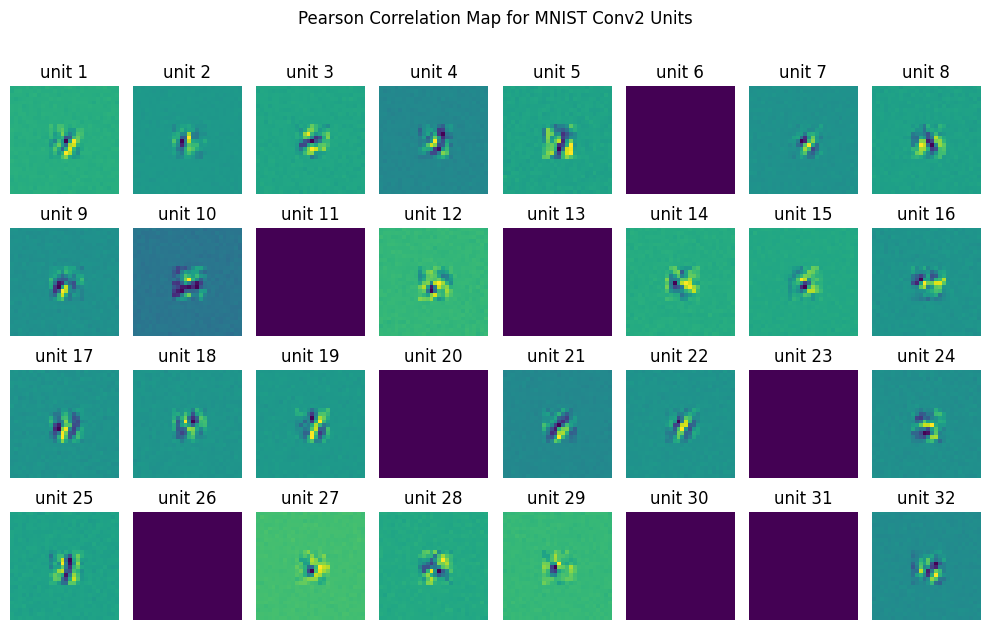

In [471]:
# Absolute = False - Visualise the RWA output as image plots
plt.style.use('default')
for i in range(rf2.shape[0]):
    plt.subplot(4, 8, i+1) # nrows, ncols, index
    plt.axis('off')
    to_show = rf_corr2[i]
    
    # if the unit is not dead (positive activation values)
    if act_conv2[i][act_conv2[i] > 0].shape[0] != 0: # negative activation values are dead units
        to_show = (to_show - to_show.min()) / (to_show.max() - to_show.min()) # normalise to [0, 1]
        plt.imshow(to_show)
    else:
        # show a black image
        plt.imshow(np.zeros((rf2.shape[1], rf2.shape[2], rf2.shape[3])))
    plt.title(f'unit {str(i+1)}', fontsize=12)
    plt.gcf().set_size_inches(7, 7)
    
# title for the entire plot
plt.suptitle(f'Pearson Correlation Map for MNIST Conv2 Units', fontsize=12)
print(np.round(float(rf2.min()), 3), np.round(float(rf2.max()), 3))
# increase the spacing between subplots
# change figure size
plt.gcf().set_size_inches(10, 6.5)
plt.tight_layout()
plt.subplots_adjust(top=0.88)
plt.show()

RF Cropping via Pearson Correlation Mask


In [472]:
# calculate the Pearson correlation between the RFs and the input noise and accumulate to obtain mask for cropping
correlation2 = torch.zeros(rf2.shape[1], rf2.shape[2], rf2.shape[3])
for i in range(rf2.shape[3]):
    correlation2[:, :, i] = CorrMask(noise2[:, :, :, i], act_conv2)

100%|██████████| 25088/25088 [00:28<00:00, 873.72it/s] 


Text(0.5, 1.0, 'Superposed PCC for MNIST RF Cropping')

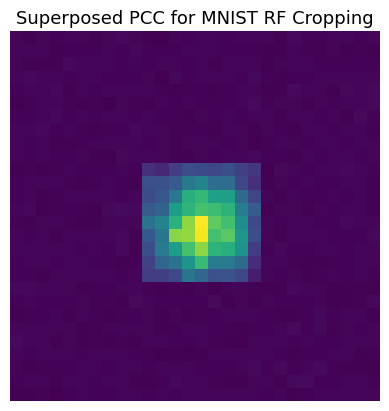

In [473]:
# Display the correlation mask
plt.style.use('default')
to_show = (correlation2 - correlation2.min()) / (correlation2.max() - correlation2.min())
plt.axis('off')
plt.imshow(to_show)
plt.title(f'Superposed PCC for MNIST RF Cropping', fontsize=13)

In [474]:
# save the correlation data
torch.save(correlation2, f'./rwa_data/mnist/mnist_rand{path_dict[zero_mean]}/correlation{path_dict[layer]}.pt')

In [476]:
# crop the RFs
# Threshold for cropping automatically set at 0.01
rf_cropped2 = []
for i in range(rf2.shape[3]): # loop through each channel
    tmp, mask = RfCrop(correlation2[:, :, i], rf2[:, :, :, i]) # crop the RFs
    rf_cropped2.append(tmp)
rf_cropped2 = torch.stack(rf_cropped2, dim=3)

Text(0.5, 1.0, 'Correlation Mask for MNIST RF Cropping')

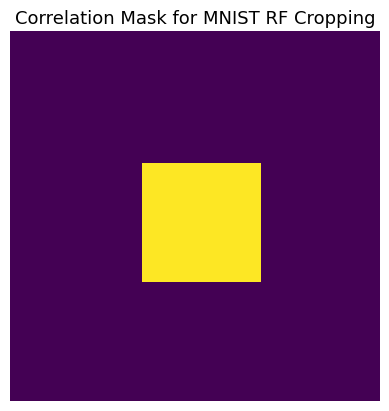

In [477]:
plt.axis('off')

plt.imshow(mask)
plt.title(f'Correlation Mask for MNIST RF Cropping', fontsize=13)

-16727.779 -2201.839


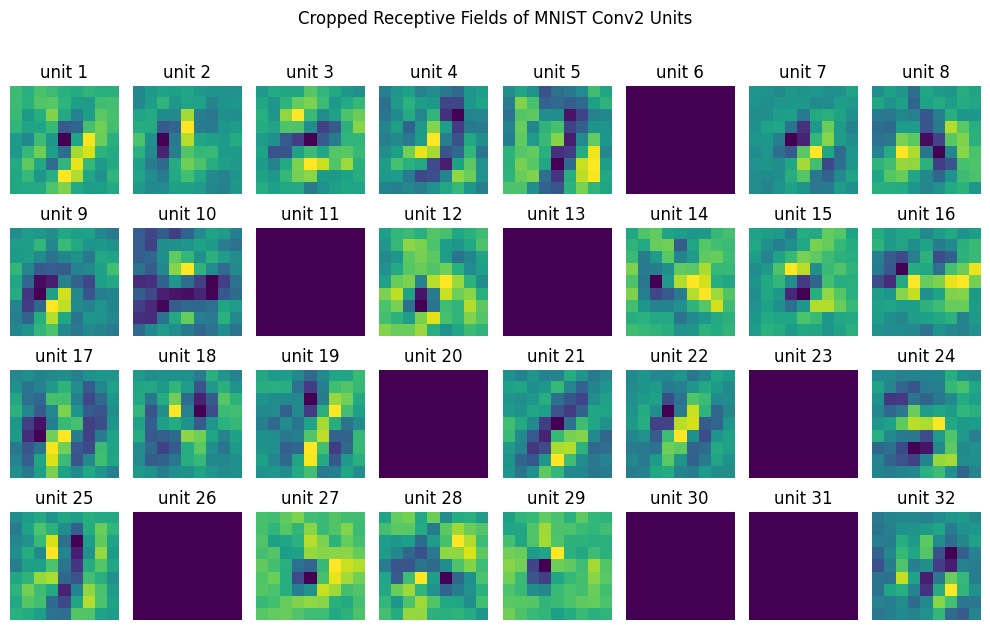

In [479]:
# Absolute = False - Visualise the RWA output as image plots
plt.style.use('default')
for i in range(rf2.shape[0]):
    plt.subplot(4, 8, i+1) # nrows, ncols, index
    plt.axis('off')
    to_show = rf_cropped2[i]
    
    # if the unit is not dead (positive activation values)
    if act_conv2[i][act_conv2[i] > 0].shape[0] != 0: # negative activation values are dead units
        to_show = (to_show - to_show.min()) / (to_show.max() - to_show.min()) # normalise to [0, 1]
        plt.imshow(to_show)
    else:
        # show a black image
        plt.imshow(np.zeros((rf2.shape[1], rf2.shape[2], rf2.shape[3])))
    plt.title(f'unit {str(i+1)}', fontsize=12)
    plt.gcf().set_size_inches(7, 7)
    
# title for the entire plot
plt.suptitle(f'Cropped Receptive Fields of MNIST Conv2 Units', fontsize=12)
print(np.round(float(rf2.min()), 3), np.round(float(rf2.max()), 3))
# increase the spacing between subplots
# change figure size
plt.gcf().set_size_inches(10, 6.5)
plt.tight_layout()
plt.subplots_adjust(top=0.88)
plt.show()

In [480]:
# save the cropped RFs
torch.save(rf_cropped2, f'./rwa_data/mnist/mnist_rand{path_dict[zero_mean]}/rf_cropped{path_dict[layer]}.pt')

Mutual Information

In [481]:
print(noise2[:, 0, 0].flatten().shape) # one pixel noise
print(act_conv2[0].flatten().shape) # one unit activation

torch.Size([50000])
torch.Size([50000])


In [482]:
# round every number in noise1 to nearest whole number
noise2_ = np.round(noise2)
act_conv2_ = np.round(act_conv2)

In [486]:
num_units = act_conv2.shape[0]
mi2 = torch.zeros((num_units, noise2.shape[1], noise2.shape[2])) # single channel

with tqdm(total = num_units * noise2.shape[1] * noise2.shape[2]) as pbar:
    for i in range(num_units):
        for j in range(noise2.shape[1]):
            for k in range(noise2.shape[2]): # go through each pixel
                mi2[i, j, k] = mutual_info_score(noise2_[:, j, k].flatten(), act_conv2_[i].flatten())
                pbar.update(1)

100%|██████████| 25088/25088 [09:11<00:00, 45.53it/s]


In [487]:
# save the cropped RFs
torch.save(mi2, f'./rwa_data/mnist/mnist_rand{path_dict[zero_mean]}/mi{path_dict[layer]}.pt')

-16727.779 -2201.839


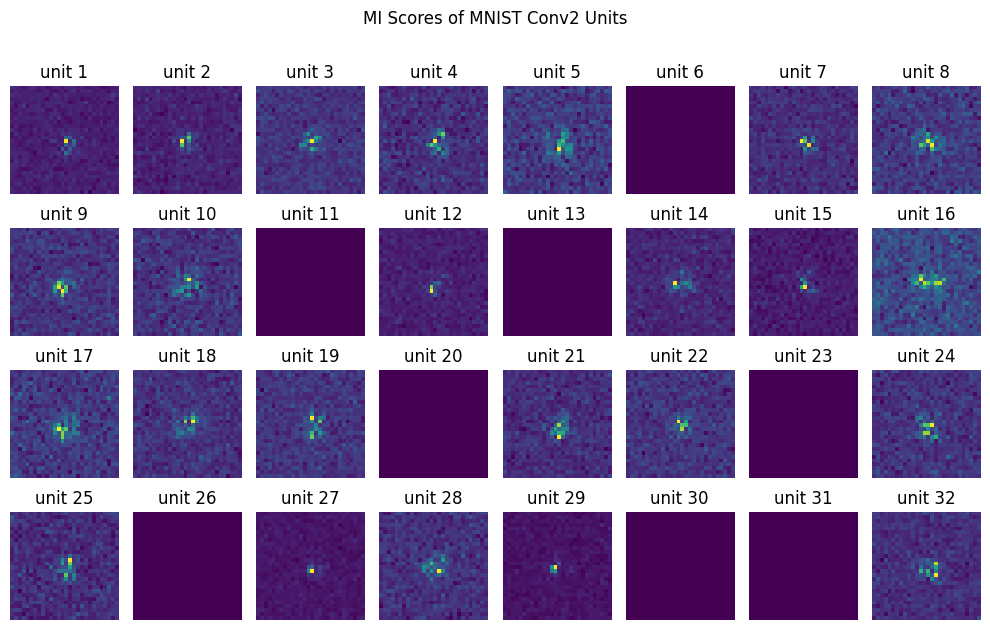

In [488]:
# Absolute = False - Visualise the RWA output as image plots
plt.style.use('default')
for i in range(rf2.shape[0]):
    plt.subplot(4, 8, i+1) # nrows, ncols, index
    plt.axis('off')
    to_show = mi2[i]
    
    # if the unit is not dead (positive activation values)
    if act_conv2[i][act_conv2[i] > 0].shape[0] != 0: # negative activation values are dead units
        to_show = (to_show - to_show.min()) / (to_show.max() - to_show.min()) # normalise to [0, 1]
        plt.imshow(to_show)
    else:
        # show a black image
        plt.imshow(np.zeros((rf2.shape[1], rf2.shape[2], rf2.shape[3])))
    plt.title(f'unit {str(i+1)}', fontsize=12)
    plt.gcf().set_size_inches(7, 7)
    
# title for the entire plot
plt.suptitle(f'MI Scores of MNIST Conv2 Units', fontsize=12)
print(np.round(float(rf2.min()), 3), np.round(float(rf2.max()), 3))
# increase the spacing between subplots
# change figure size
plt.gcf().set_size_inches(10, 6.5)
plt.tight_layout()
plt.subplots_adjust(top=0.88)
plt.show()

In [489]:
# crop the RFs
# Threshold for cropping automatically set at 0.01
mi_cropped2, _ = RfCrop(correlation2[:, :, 0], mi2[:, :, :]) # crop the RFs

-16727.779 -2201.839


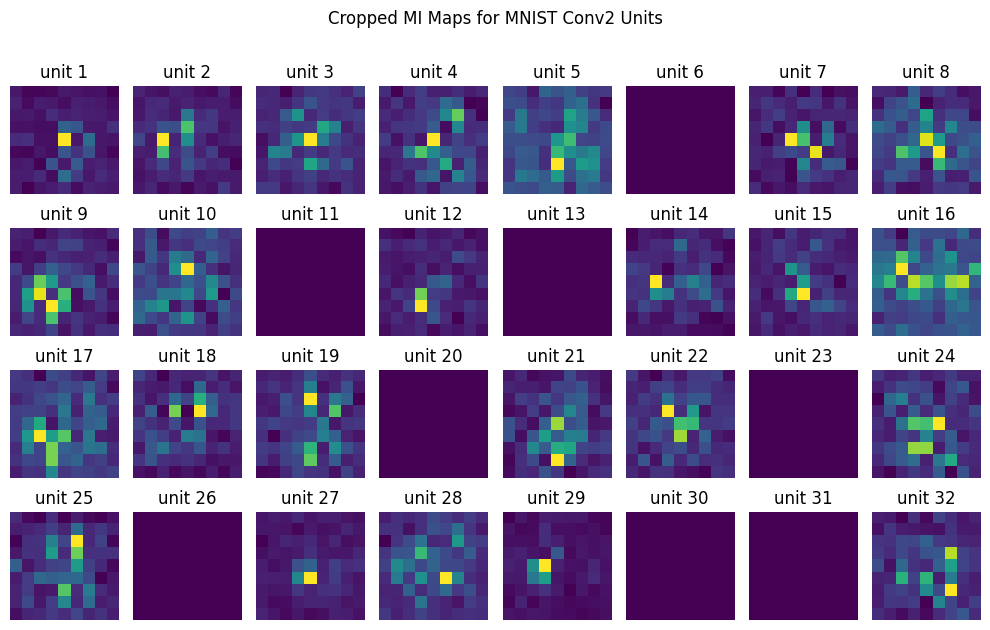

In [490]:
# Absolute = False - Visualise the RWA output as image plots
plt.style.use('default')
for i in range(rf2.shape[0]):
    plt.subplot(4, 8, i+1) # nrows, ncols, index
    plt.axis('off')
    to_show = mi_cropped2[i]
    
    # if the unit is not dead (positive activation values)
    if act_conv2[i][act_conv2[i] > 0].shape[0] != 0: # negative activation values are dead units
        to_show = (to_show - to_show.min()) / (to_show.max() - to_show.min()) # normalise to [0, 1]
        plt.imshow(to_show)
    else:
        # show a black image
        plt.imshow(np.zeros((rf2.shape[1], rf2.shape[2], rf2.shape[3])))
    plt.title(f'unit {str(i+1)}', fontsize=12)
    plt.gcf().set_size_inches(7, 7)
    
# title for the entire plot
plt.suptitle(f'Cropped MI Maps for MNIST Conv2 Units', fontsize=12)
print(np.round(float(rf2.min()), 3), np.round(float(rf2.max()), 3))
# increase the spacing between subplots
# change figure size
plt.gcf().set_size_inches(10, 6.5)
plt.tight_layout()
plt.subplots_adjust(top=0.88)
plt.show()

Response-Weighted Covariance - Normal RWA

In [491]:
# crop noise to the same dimensions as the cropped RFs
noise_cropped2 = torch.zeros(noise2.shape[0], rf_cropped2.shape[1], rf_cropped2.shape[2], rf_cropped2.shape[3])
for i in range(noise_cropped2.shape[3]):
    tmp, _ = RfCrop(correlation2[:, :, i], noise2[:, :, :, i])
    noise_cropped2[:, :, :, i] = tmp
print(noise_cropped2.shape)

torch.Size([50000, 9, 9, 1])


In [492]:
torch.save(noise_cropped2, f'./rwa_data/mnist/mnist_rand{path_dict[zero_mean]}/noise_cropped{path_dict[layer]}.pt')

In [493]:
# unravel noise and RFs for RWC + create input for RWC
noise_cropped_flat2 = noise_cropped2.view(noise_cropped2.shape[0], -1) # 50000, 8*8*3=192
rf_cropped_flat2 = rf_cropped2.view(rf_cropped2.shape[0], -1) # 16, 8*8*3=192

# reformat magnitudes of rf data to fit with noise
if zero_mean:
    rf = ((rf_cropped_flat2 - rf_cropped_flat2.min()) / (rf_cropped_flat2.max() - rf_cropped_flat2.min()) - 0.5) * 255 # normalise to [-127.5, 127.5]
else:
    rf = (rf_cropped_flat2 - rf_cropped_flat2.min()) / (rf_cropped_flat2.max() - rf_cropped_flat2.min()) * 255 # normalise to [0, 255]
    
# compute input data for RWC
# mu = noise - rf
mu = torch.zeros(rf_cropped_flat2.shape[0], noise_cropped_flat2.shape[0], noise_cropped_flat2.shape[1])
for i in range(mu.shape[0]):
    mu[i] = noise_cropped_flat2 - rf[i]

# RWC
cov2 = RWC(act_conv2, mu)

100%|██████████| 1600000/1600000 [00:54<00:00, 29507.10it/s]


In [494]:
print(f"Shape of mu: {mu.shape}")
print(f"Shape of cov2: {cov2.shape}")

Shape of mu: torch.Size([32, 50000, 81])
Shape of cov2: torch.Size([32, 81, 81])


In [495]:
# save the pca covariance data
torch.save(cov2, f'./rwa_data/mnist/mnist_rand{path_dict[zero_mean]}/cov{path_dict[layer]}.pt')

In [496]:
# Principal Component Analysis
eigenvalues2 = torch.zeros(cov2.shape[0], cov2.shape[1])
eigenvectors2 = torch.zeros((cov2.shape[0], cov2.shape[1], cov2.shape[1])) # store the PCA components

# Get relevant results
for i in range(cov2.shape[0]): # loop through each unit
    eigen = np.linalg.eigh(cov2[i])
    eigenvectors2[i] = torch.tensor(eigen.eigenvectors)
    eigenvalues2[i] = torch.tensor(eigen.eigenvalues)

In [497]:
# Store the eigenvalues and eigenvectors
eigen2 = (eigenvectors2, eigenvalues2)
with open(f'./rwa_data/mnist/mnist_rand{path_dict[zero_mean]}/eigen{path_dict[layer]}.pkl', 'wb') as f:
    pickle.dump(eigen2, f)

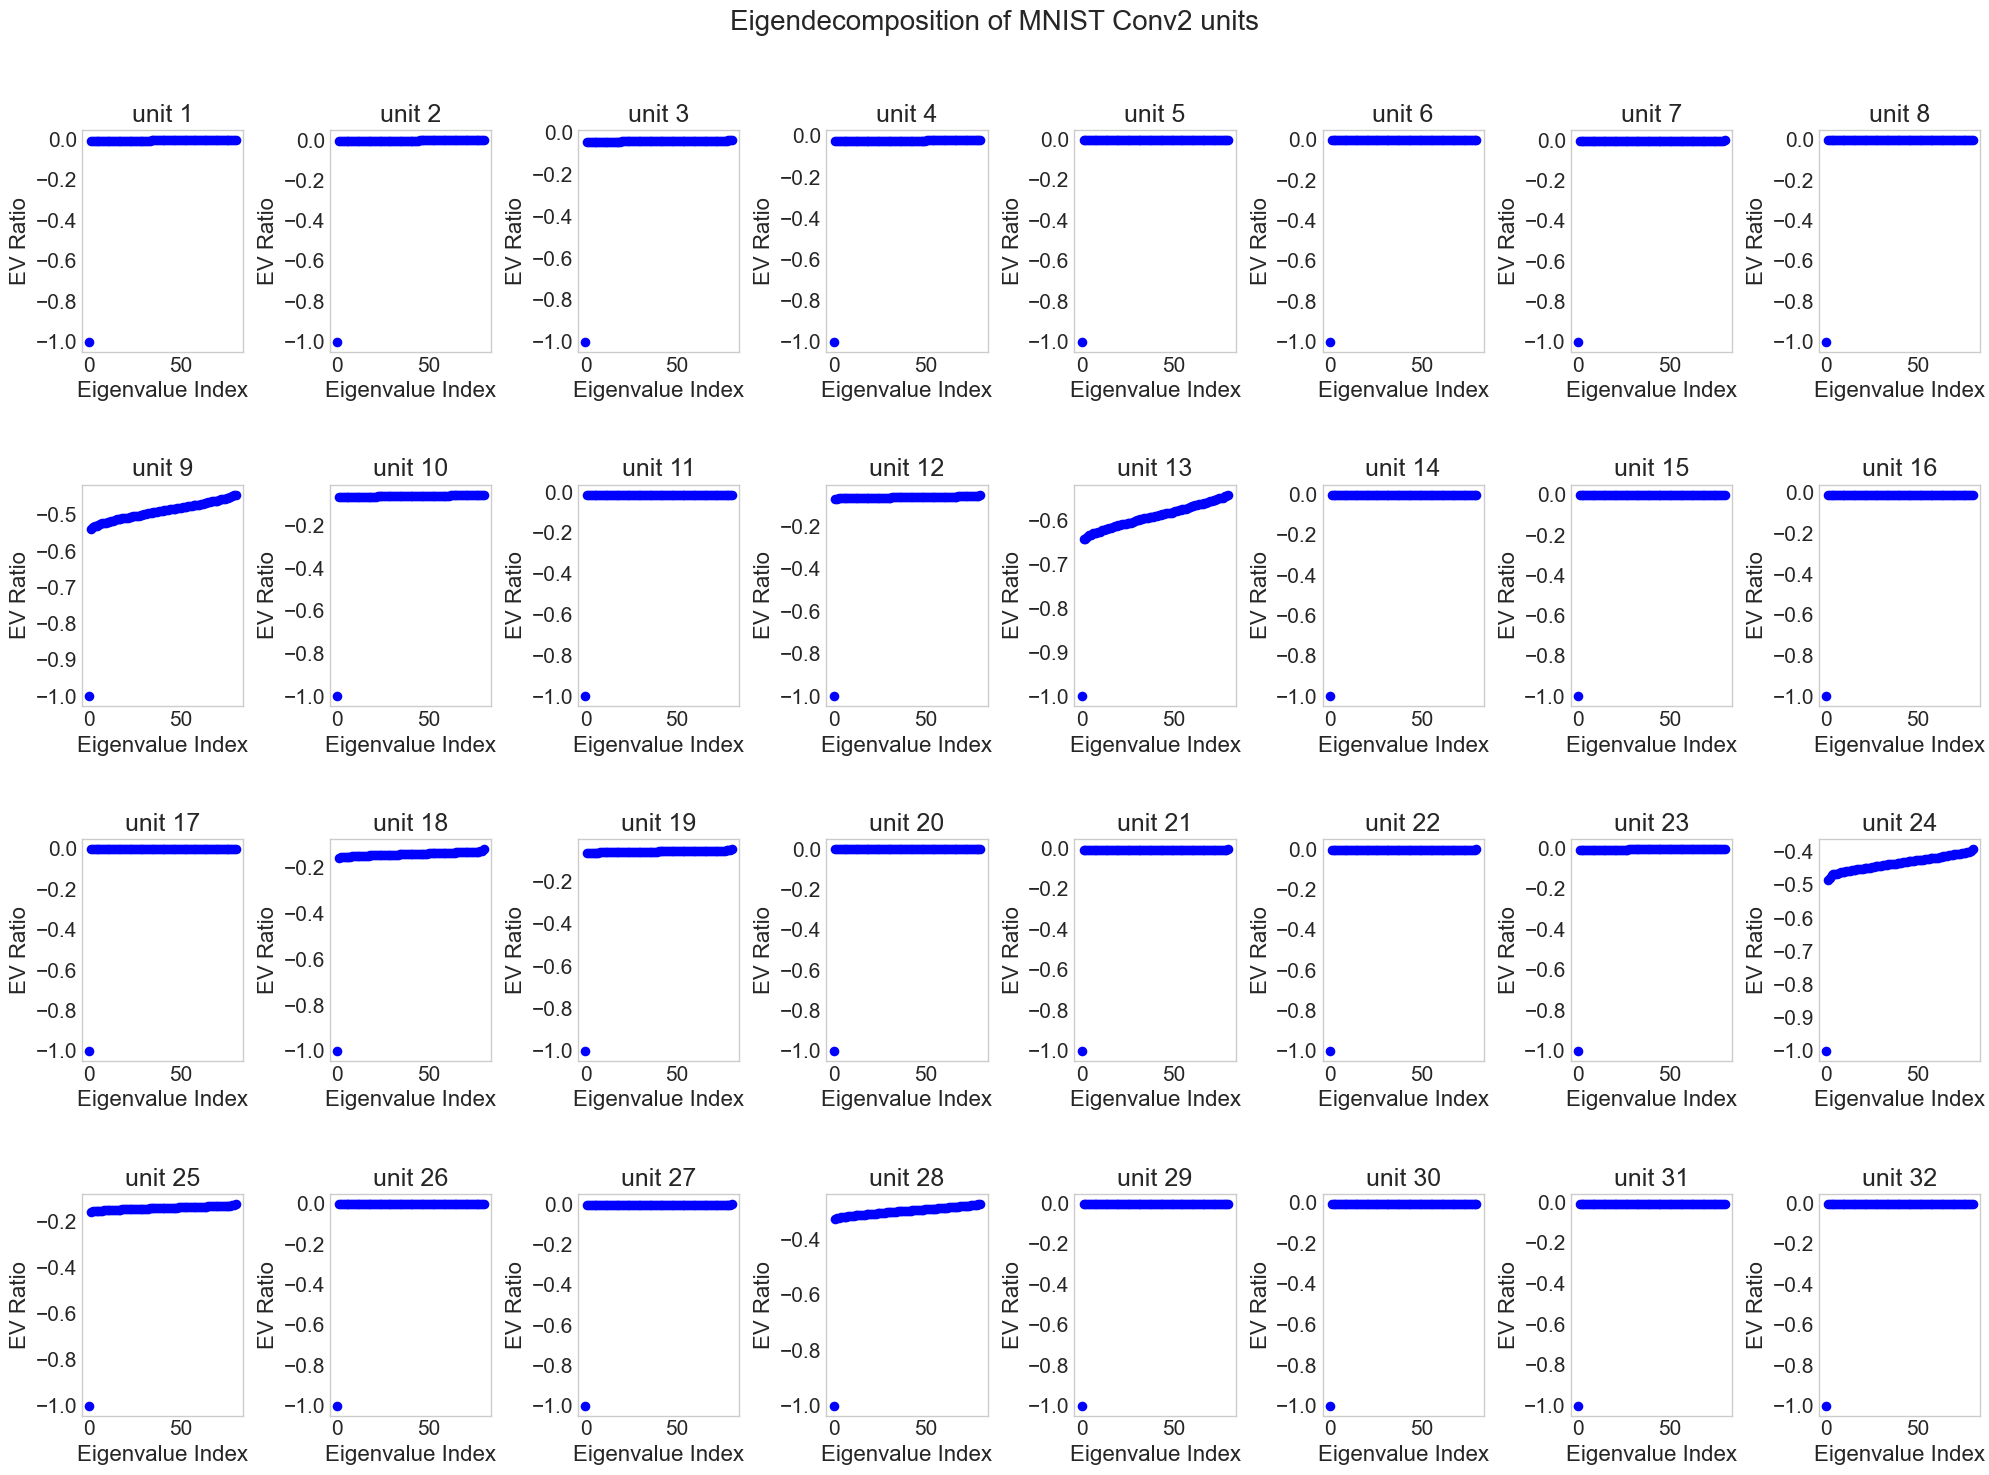

In [514]:
# visualise the eigenvalues
plt.style.use('seaborn-v0_8-whitegrid')
for i in range(cov2.shape[0]):
    plt.subplot(4, 8, i+1)
    y = eigenvalues2[i]
    # reverse the order of the eigenvalues
    plt.scatter(range(len(eigenvalues2[i])), y/abs(y).max(), s=35, c='blue')
    plt.xlabel('Eigenvalue Index', fontsize=16)
    plt.ylabel('EV Ratio', fontsize=16)
    plt.title('unit ' + str(i+1), fontsize=18)
    plt.gcf().set_size_inches(13, 10)
    # change axis font size
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    plt.grid(False)
    
plt.suptitle('Eigendecomposition of MNIST Conv2 units', fontsize=20) 
plt.gcf().set_size_inches(20, 15)
plt.tight_layout()
plt.subplots_adjust(top=0.9)
# add vertical space between subplots
plt.subplots_adjust(hspace=0.6)
plt.show()

-16727.779 -2201.839


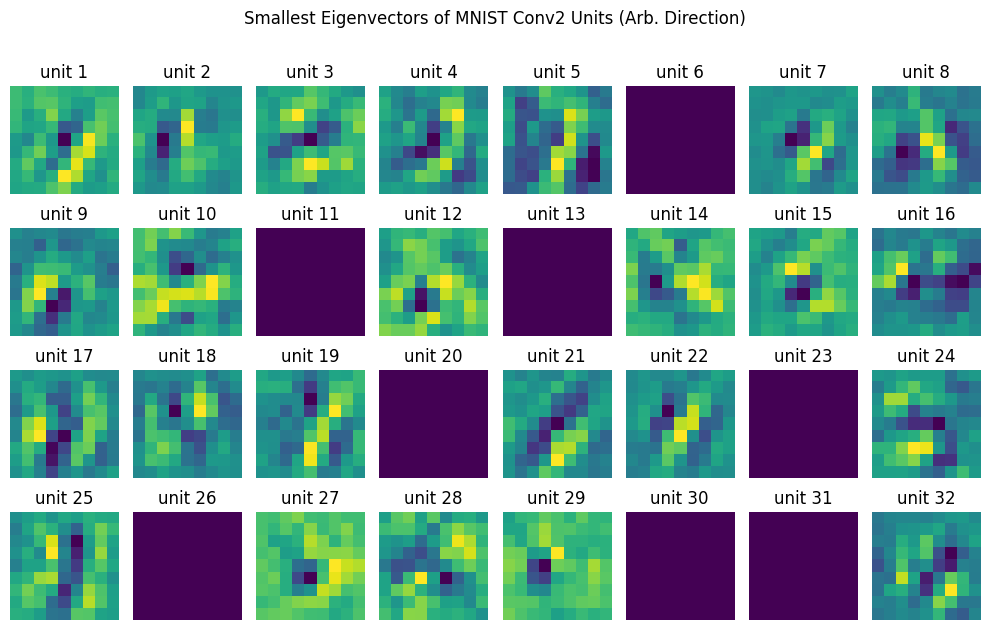

In [515]:
# Absolute = False - Visualise the RWA output as image plots
plt.style.use('default')
for i in range(rf2.shape[0]):
    plt.subplot(4, 8, i+1) # nrows, ncols, index
    plt.axis('off')
    x = eigenvectors2[i, :, 0].reshape(rf_cropped2.shape[1], rf_cropped2.shape[2], rf_cropped2.shape[3])
    to_show = (x - x.min()) / (x.max() - x.min())
    
    # if the unit is not dead (positive activation values)
    if act_conv2[i][act_conv2[i] > 0].shape[0] != 0: # negative activation values are dead units
        to_show = (to_show - to_show.min()) / (to_show.max() - to_show.min()) # normalise to [0, 1]
        plt.imshow(to_show)
    else:
        # show a black image
        plt.imshow(np.zeros((rf2.shape[1], rf2.shape[2], rf2.shape[3])))
    plt.title(f'unit {str(i+1)}', fontsize=12)
    plt.gcf().set_size_inches(7, 7)
    
# title for the entire plot
plt.suptitle(f'Smallest Eigenvectors of MNIST Conv2 Units (Arb. Direction)', fontsize=12)
print(np.round(float(rf2.min()), 3), np.round(float(rf2.max()), 3))
# increase the spacing between subplots
# change figure size
plt.gcf().set_size_inches(10, 6.5)
plt.tight_layout()
plt.subplots_adjust(top=0.88)
plt.show()

-16727.779 -2201.839


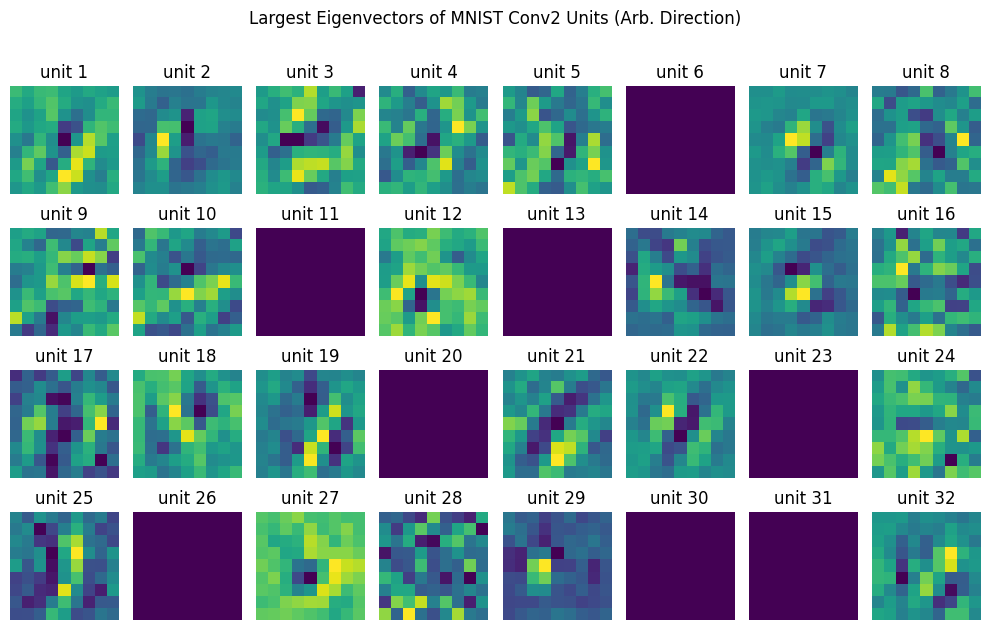

In [516]:
# Absolute = False - Visualise the RWA output as image plots
plt.style.use('default')
for i in range(rf2.shape[0]):
    plt.subplot(4, 8, i+1) # nrows, ncols, index
    plt.axis('off')
    x = eigenvectors2[i, :, -1].reshape(rf_cropped2.shape[1], rf_cropped2.shape[2], rf_cropped2.shape[3])
    to_show = (x - x.min()) / (x.max() - x.min())
    
    # if the unit is not dead (positive activation values)
    if act_conv2[i][act_conv2[i] > 0].shape[0] != 0: # negative activation values are dead units
        to_show = (to_show - to_show.min()) / (to_show.max() - to_show.min()) # normalise to [0, 1]
        plt.imshow(to_show)
    else:
        # show a black image
        plt.imshow(np.zeros((rf2.shape[1], rf2.shape[2], rf2.shape[3])))
    plt.title(f'unit {str(i+1)}', fontsize=12)
    plt.gcf().set_size_inches(7, 7)
    
# title for the entire plot
plt.suptitle(f'Largest Eigenvectors of MNIST Conv2 Units (Arb. Direction)', fontsize=12)
print(np.round(float(rf2.min()), 3), np.round(float(rf2.max()), 3))
# increase the spacing between subplots
# change figure size
plt.gcf().set_size_inches(10, 6.5)
plt.tight_layout()
plt.subplots_adjust(top=0.88)
plt.show()

# Conv2 - Zero Mean

In [ ]:
# load existing data if already recorded
path_dict = {True: '_0mean', False:'', 'conv1': 1, 'conv2': 2}

batch_num = 100
batch_size = 500
zero_mean = True
layer = 'conv2'

act_conv2 = torch.load(f'./rwa_data/mnist/mnist_rand{path_dict[zero_mean]}/act{path_dict[layer]}.pt')
noise2 = torch.load(f'./rwa_data/mnist/mnist_rand{path_dict[zero_mean]}/noise{path_dict[layer]}.pt')

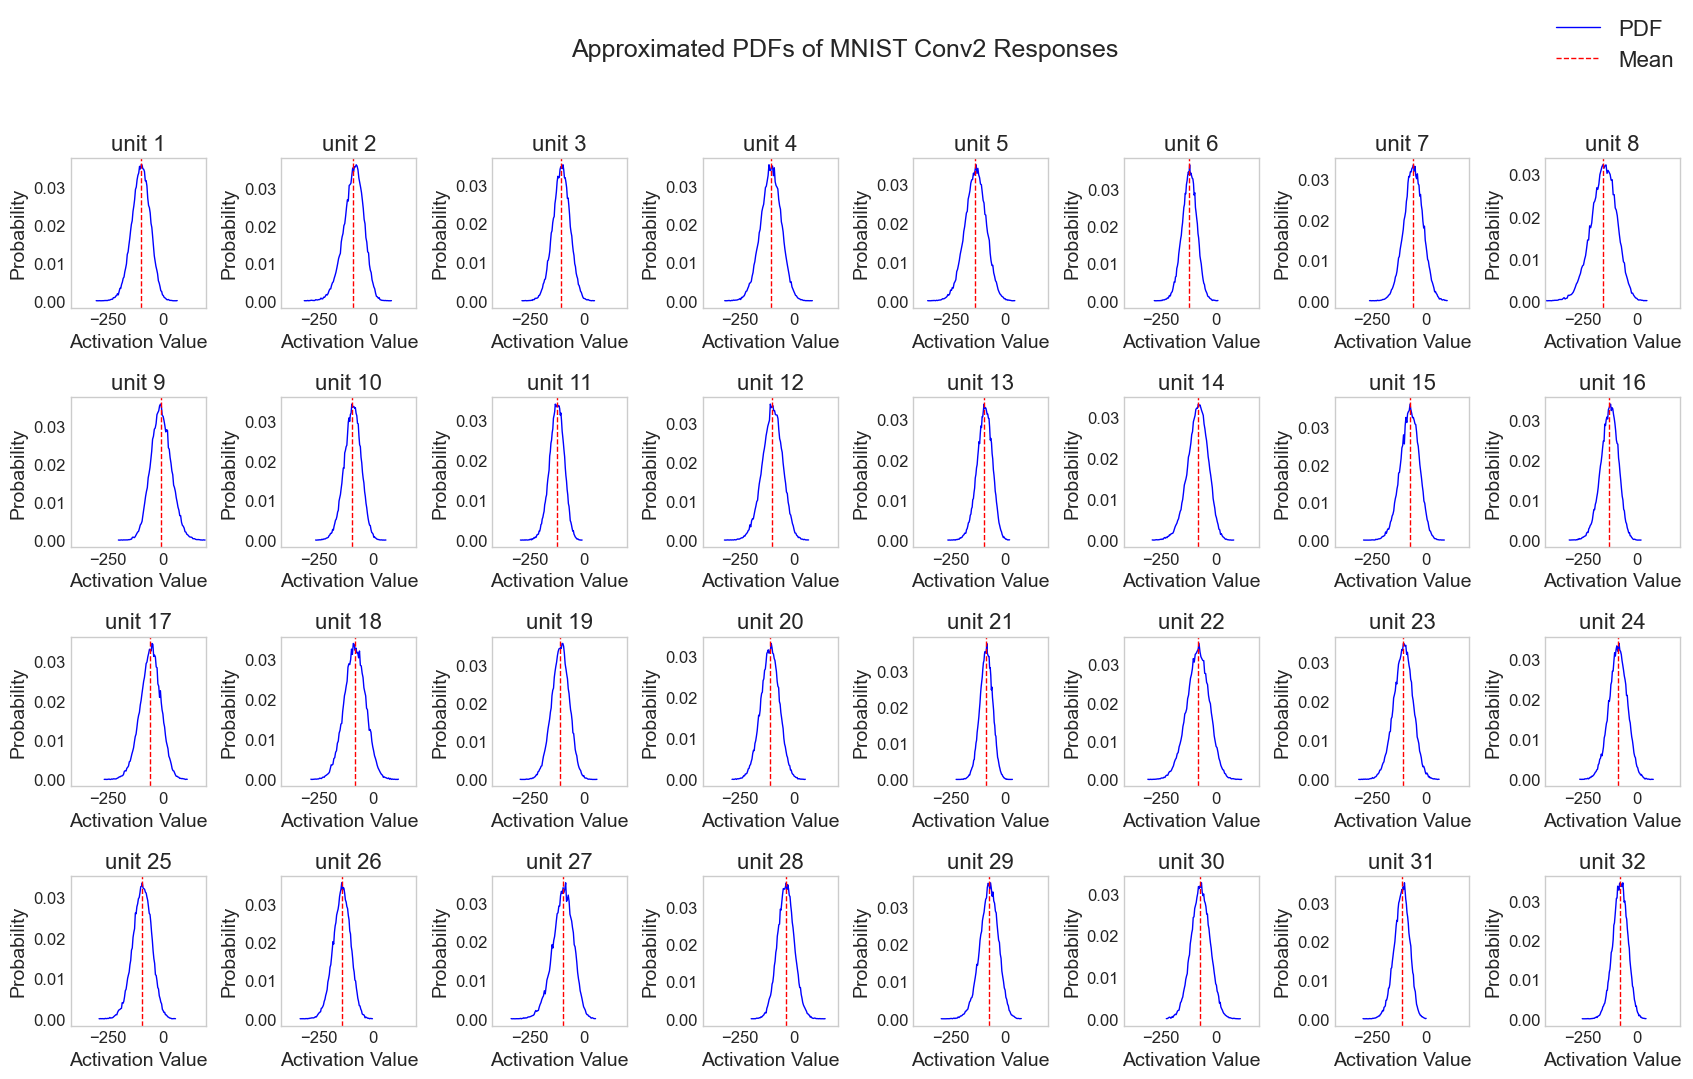

In [523]:
# PDFs of conv1 responses
# gaussian shape is a result of convolution
plt.style.use('seaborn-v0_8-whitegrid')
for i in range(act_conv2.shape[0]):
    plt.subplot(8, 8, i+1)
    plt.xlim(act_conv2.min(), act_conv2.max())
    
    if act_conv2[i][act_conv2[i] != 0].shape[0] != 0: # if unit is not dead
        counts, bin_edges = np.histogram(act_conv2[i], bins=100)
        pdf = counts / sum(counts) # normalise the counts to get the PDF
        bin_centers = (bin_edges[1:] + bin_edges[:-1]) / 2
        plt.plot(bin_centers, pdf, color='blue', linewidth=1)
        plt.xlabel('Activation Value', fontsize=14)
        plt.ylabel('Probability', fontsize=14)
        plt.axvline(act_conv2[i].mean(), color='red', linestyle='dashed', linewidth=1)
        plt.title('unit ' + str(i+1), fontsize=16)
    else:
        # plot shows text saying 'inactive'
        plt.text(0.5, 0.5, 'inactive', horizontalalignment='center', verticalalignment='center')
        plt.title('unit ' + str(i+1), fontsize=16)
        plt.axis('off')
    plt.gcf().set_size_inches(14, 17)
    
    # turn off gird
    plt.grid(False)
    # set xtick and ytick size
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)

plt.suptitle('Approximated PDFs of MNIST Conv2 Responses', fontsize=18)

# add a legend
plt.figlegend(['PDF', 'Mean'], loc='upper right', fontsize=16)

# add a boundary box to the legend
# change figure size
plt.gcf().set_size_inches(17, 20)
plt.tight_layout()

# add space below the title
plt.subplots_adjust(top=0.92)
plt.subplots_adjust(hspace=0.6)
plt.show()

RWA

In [526]:
# RWA - unbiased RF estimation, absolute false
rf2 = RWA(act_conv2, noise2, absolute=False)
print(rf2.shape)

100%|██████████| 1600000/1600000 [00:50<00:00, 31627.70it/s]

Shape of receptive field list: torch.Size([32, 28, 28, 1])
torch.Size([32, 28, 28, 1])


In [527]:
# Save the RWA data
torch.save(rf2, f'./rwa_data/mnist/mnist_rand{path_dict[zero_mean]}/rf{path_dict[layer]}.pt')

-811.224 945.801


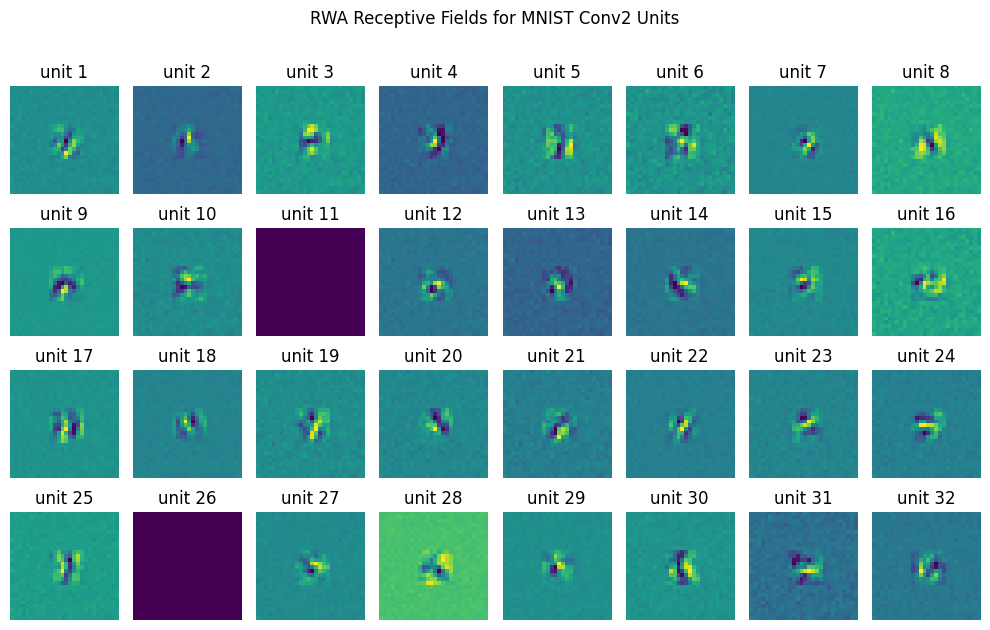

In [528]:
# Absolute = False - Visualise the RWA output as image plots
plt.style.use('default')
for i in range(rf2.shape[0]):
    plt.subplot(4, 8, i+1) # nrows, ncols, index
    plt.axis('off')
    to_show = rf2[i]
    
    # if the unit is not dead (positive activation values)
    if act_conv2[i][act_conv2[i] > 0].shape[0] != 0: # negative activation values are dead units
        to_show = (to_show - to_show.min()) / (to_show.max() - to_show.min()) # normalise to [0, 1]
        plt.imshow(to_show)
    else:
        # show a black image
        plt.imshow(np.zeros((rf2.shape[1], rf2.shape[2], rf2.shape[3])))
    plt.title(f'unit {str(i+1)}', fontsize=12)
    plt.gcf().set_size_inches(7, 7)
    
# title for the entire plot
plt.suptitle(f'RWA Receptive Fields for MNIST Conv2 Units', fontsize=12)
print(np.round(float(rf2.min()), 3), np.round(float(rf2.max()), 3))
# increase the spacing between subplots
# change figure size
plt.gcf().set_size_inches(10, 6.5)
plt.tight_layout()
plt.subplots_adjust(top=0.88)
plt.show()

Receptive Field Estimation via Pearson Correlation

In [529]:
# Absolute = false - gets the correlation between the RF and the noise for each unit
rf_corr2 = torch.zeros(rf2.shape)
for i in range(rf2.shape[3]): # loop through each channel
    rf_corr2[:, :, :, i] = CorrRWA(act_conv2, noise2[:, :, :, i])# Absolute = false - gets the correlation between the RF and the noise for each unit
rf_corr2 = torch.zeros(rf2.shape)
for i in range(rf2.shape[3]): # loop through each channel
    rf_corr2[:, :, :, i] = CorrRWA(act_conv2, noise2[:, :, :, i])

100%|██████████| 25088/25088 [00:52<00:00, 482.38it/s]


In [530]:
# Save the RWA data
torch.save(rf_corr2, f'./rwa_data/mnist/mnist_rand{path_dict[zero_mean]}/rf_corr{path_dict[layer]}.pt')

-811.224 945.801


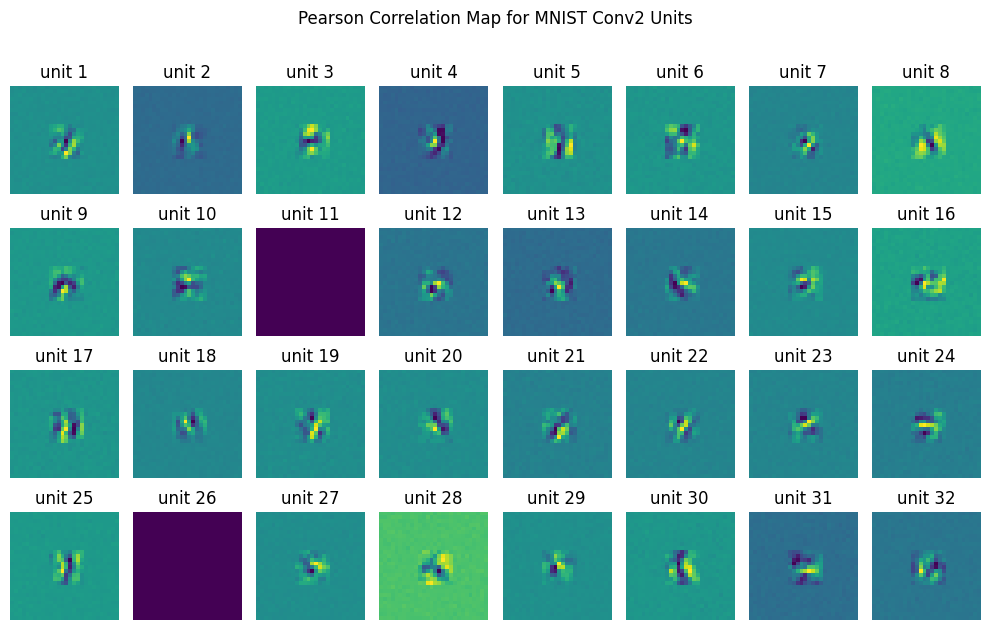

In [531]:
# Absolute = False - Visualise the RWA output as image plots
plt.style.use('default')
for i in range(rf2.shape[0]):
    plt.subplot(4, 8, i+1) # nrows, ncols, index
    plt.axis('off')
    to_show = rf_corr2[i]
    
    # if the unit is not dead (positive activation values)
    if act_conv2[i][act_conv2[i] > 0].shape[0] != 0: # negative activation values are dead units
        to_show = (to_show - to_show.min()) / (to_show.max() - to_show.min()) # normalise to [0, 1]
        plt.imshow(to_show)
    else:
        # show a black image
        plt.imshow(np.zeros((rf2.shape[1], rf2.shape[2], rf2.shape[3])))
    plt.title(f'unit {str(i+1)}', fontsize=12)
    plt.gcf().set_size_inches(7, 7)
    
# title for the entire plot
plt.suptitle(f'Pearson Correlation Map for MNIST Conv2 Units', fontsize=12)
print(np.round(float(rf2.min()), 3), np.round(float(rf2.max()), 3))
# increase the spacing between subplots
# change figure size
plt.gcf().set_size_inches(10, 6.5)
plt.tight_layout()
plt.subplots_adjust(top=0.88)
plt.show()

RF Cropping via Pearson Correlation Mask


In [532]:
# crop the RFs
# Threshold for cropping automatically set at 0.01
rf_cropped2 = []
for i in range(rf2.shape[3]): # loop through each channel
    tmp, mask = RfCrop(correlation2[:, :, i], rf2[:, :, :, i]) # crop the RFs
    rf_cropped2.append(tmp)
rf_cropped2 = torch.stack(rf_cropped2, dim=3)

-811.224 945.801


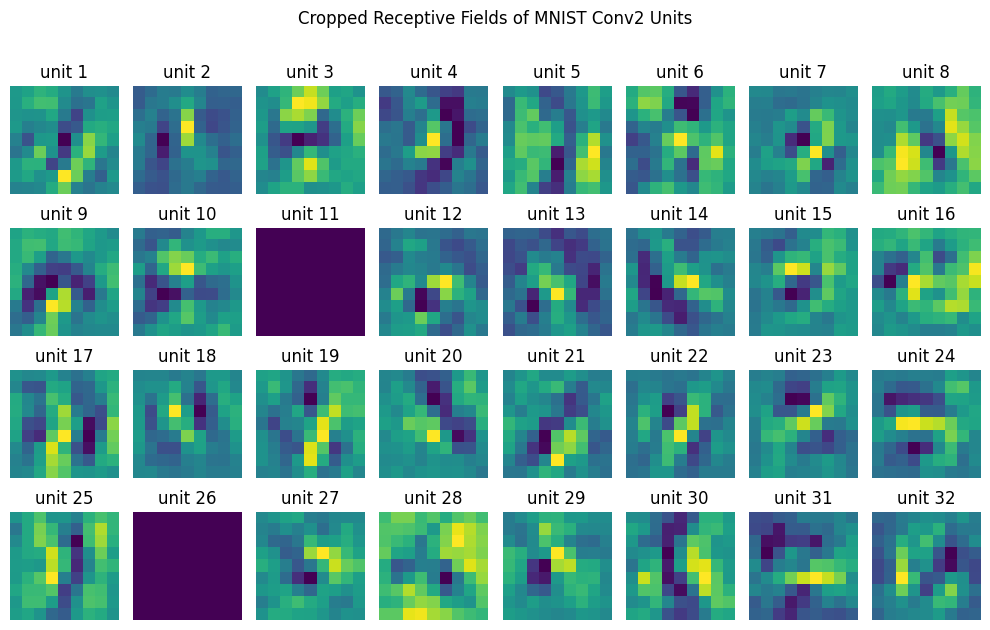

In [533]:
# Absolute = False - Visualise the RWA output as image plots
plt.style.use('default')
for i in range(rf2.shape[0]):
    plt.subplot(4, 8, i+1) # nrows, ncols, index
    plt.axis('off')
    to_show = rf_cropped2[i]
    
    # if the unit is not dead (positive activation values)
    if act_conv2[i][act_conv2[i] > 0].shape[0] != 0: # negative activation values are dead units
        to_show = (to_show - to_show.min()) / (to_show.max() - to_show.min()) # normalise to [0, 1]
        plt.imshow(to_show)
    else:
        # show a black image
        plt.imshow(np.zeros((rf2.shape[1], rf2.shape[2], rf2.shape[3])))
    plt.title(f'unit {str(i+1)}', fontsize=12)
    plt.gcf().set_size_inches(7, 7)
    
# title for the entire plot
plt.suptitle(f'Cropped Receptive Fields of MNIST Conv2 Units', fontsize=12)
print(np.round(float(rf2.min()), 3), np.round(float(rf2.max()), 3))
# increase the spacing between subplots
# change figure size
plt.gcf().set_size_inches(10, 6.5)
plt.tight_layout()
plt.subplots_adjust(top=0.88)
plt.show()

In [534]:
# save the cropped RFs
torch.save(rf_cropped2, f'./rwa_data/mnist/mnist_rand{path_dict[zero_mean]}/rf_cropped{path_dict[layer]}.pt')

Response-Weighted Covariance - Normal RWA

In [535]:
# crop noise to the same dimensions as the cropped RFs
noise_cropped2 = torch.zeros(noise2.shape[0], rf_cropped2.shape[1], rf_cropped2.shape[2], rf_cropped2.shape[3])
for i in range(noise_cropped2.shape[3]):
    tmp, _ = RfCrop(correlation2[:, :, i], noise2[:, :, :, i])
    noise_cropped2[:, :, :, i] = tmp
print(noise_cropped2.shape)

torch.Size([50000, 9, 9, 1])


In [536]:
torch.save(noise_cropped2, f'./rwa_data/mnist/mnist_rand{path_dict[zero_mean]}/noise_cropped{path_dict[layer]}.pt')

In [537]:
# unravel noise and RFs for RWC + create input for RWC
noise_cropped_flat2 = noise_cropped2.view(noise_cropped2.shape[0], -1) # 50000, 8*8*3=192
rf_cropped_flat2 = rf_cropped2.view(rf_cropped2.shape[0], -1) # 16, 8*8*3=192

# reformat magnitudes of rf data to fit with noise
if zero_mean:
    rf = ((rf_cropped_flat2 - rf_cropped_flat2.min()) / (rf_cropped_flat2.max() - rf_cropped_flat2.min()) - 0.5) * 255 # normalise to [-127.5, 127.5]
else:
    rf = (rf_cropped_flat2 - rf_cropped_flat2.min()) / (rf_cropped_flat2.max() - rf_cropped_flat2.min()) * 255 # normalise to [0, 255]
    
# compute input data for RWC
# mu = noise - rf
mu = torch.zeros(rf_cropped_flat2.shape[0], noise_cropped_flat2.shape[0], noise_cropped_flat2.shape[1])
for i in range(mu.shape[0]):
    mu[i] = noise_cropped_flat2 - rf[i]

# RWC
cov2 = RWC(act_conv2, mu)

100%|██████████| 1600000/1600000 [01:24<00:00, 18983.37it/s]


In [538]:
# save the pca covariance data
torch.save(cov2, f'./rwa_data/mnist/mnist_rand{path_dict[zero_mean]}/cov{path_dict[layer]}.pt')

In [539]:
# Principal Component Analysis
eigenvalues2 = torch.zeros(cov2.shape[0], cov2.shape[1])
eigenvectors2 = torch.zeros((cov2.shape[0], cov2.shape[1], cov2.shape[1])) # store the PCA components

# Get relevant results
for i in range(cov2.shape[0]): # loop through each unit
    eigen = np.linalg.eigh(cov2[i])
    eigenvectors2[i] = torch.tensor(eigen.eigenvectors)
    eigenvalues2[i] = torch.tensor(eigen.eigenvalues)

In [540]:
# Store the eigenvalues and eigenvectors
eigen2 = (eigenvectors2, eigenvalues2)
with open(f'./rwa_data/mnist/mnist_rand{path_dict[zero_mean]}/eigen{path_dict[layer]}.pkl', 'wb') as f:
    pickle.dump(eigen2, f)

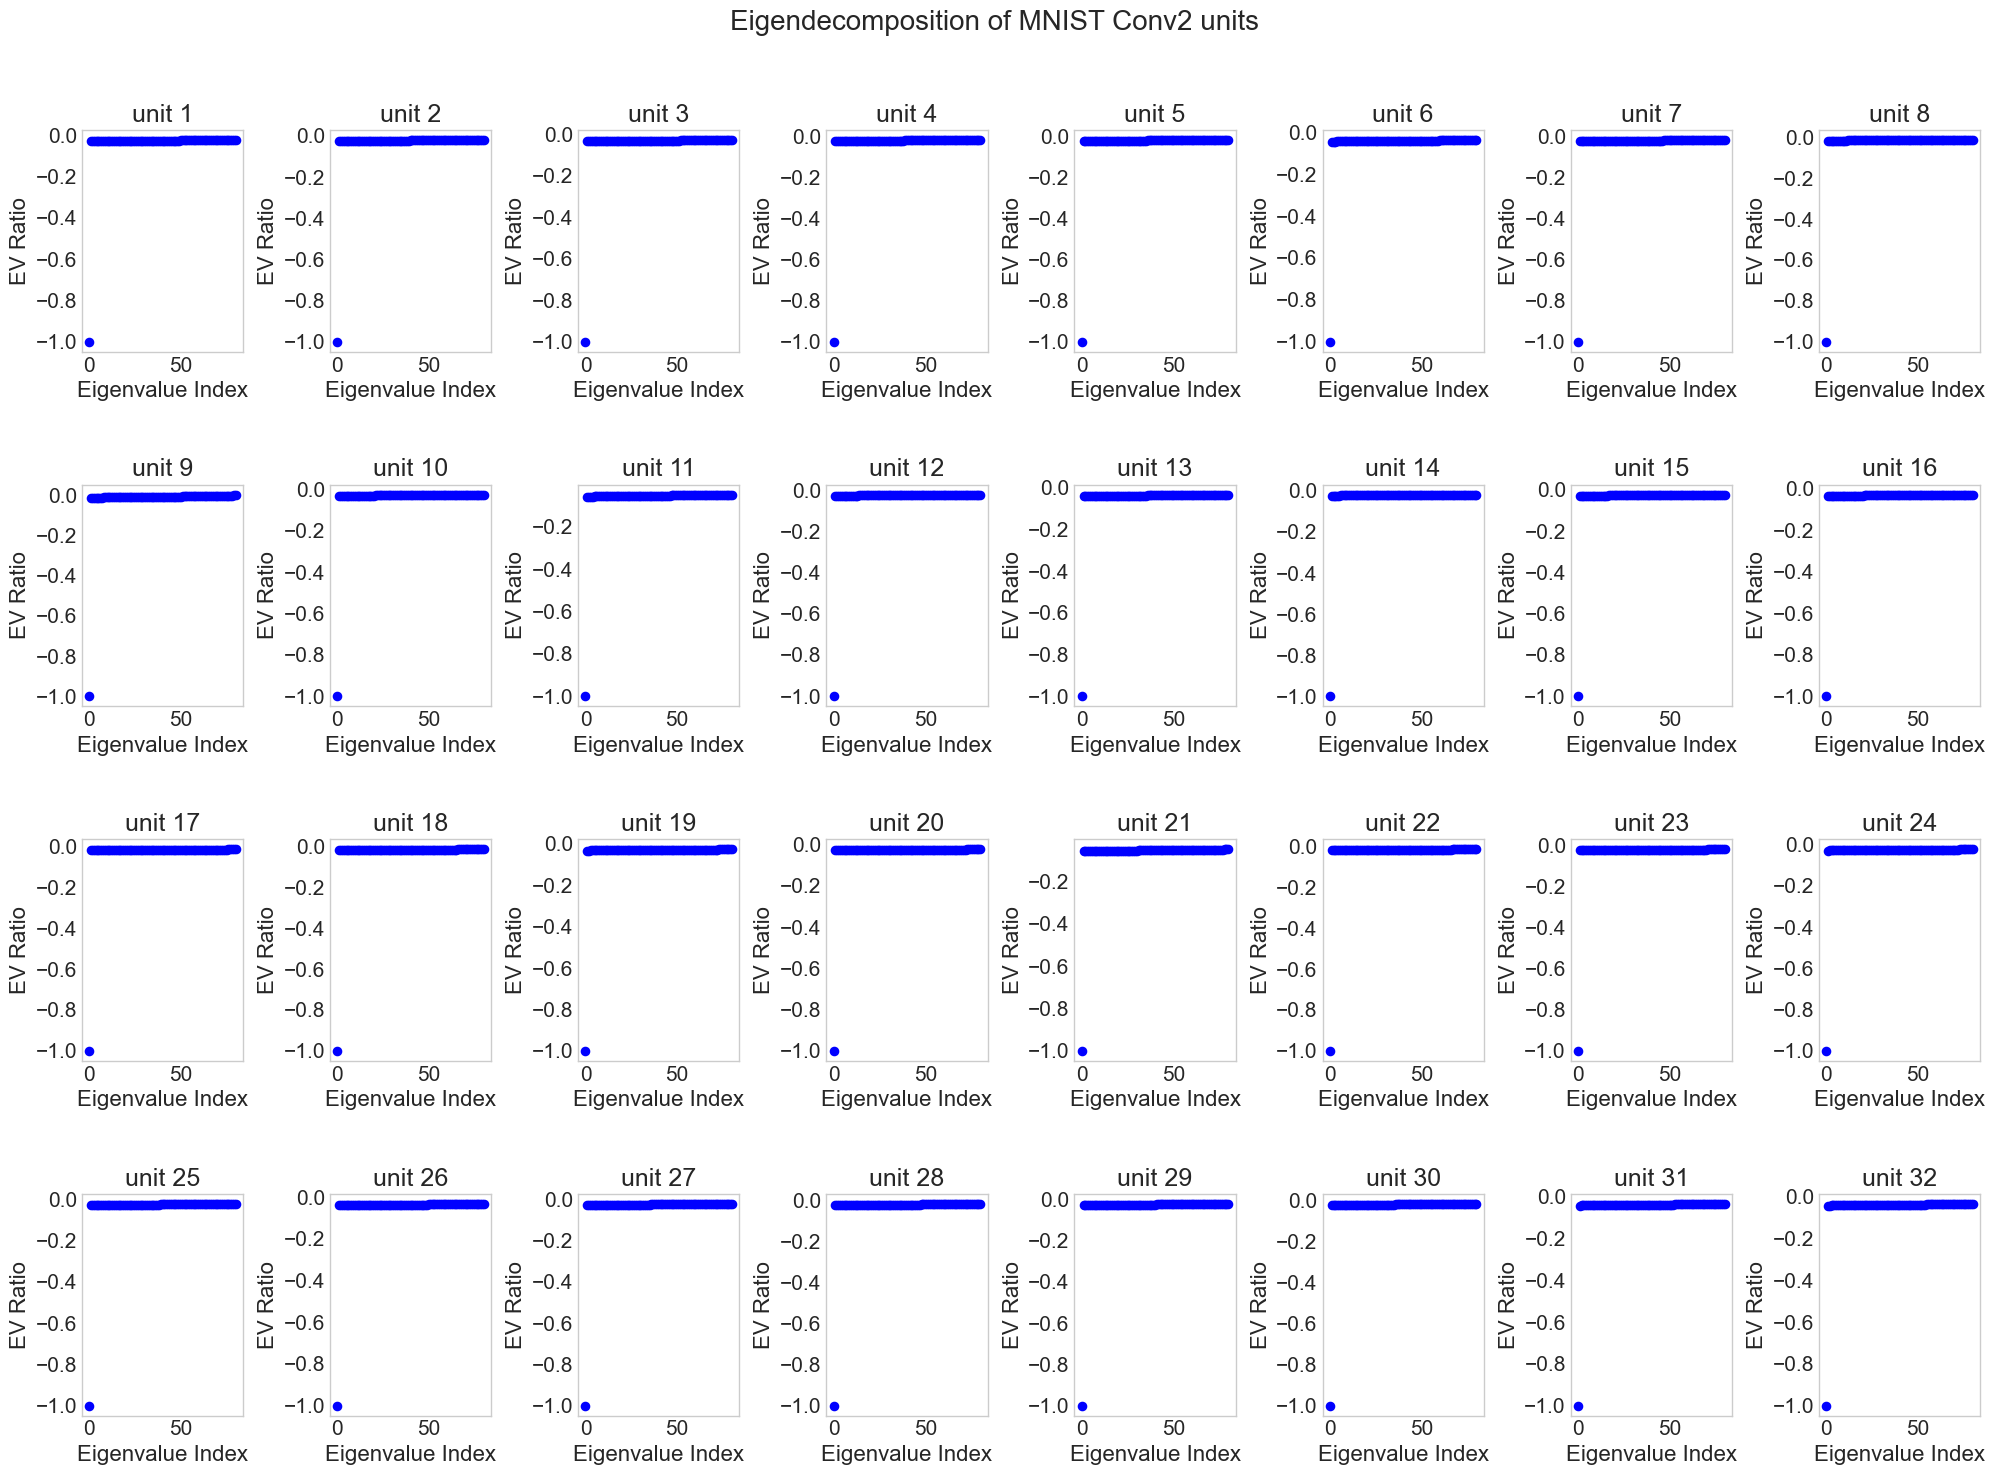

In [541]:
# visualise the eigenvalues
plt.style.use('seaborn-v0_8-whitegrid')
for i in range(cov2.shape[0]):
    plt.subplot(4, 8, i+1)
    y = eigenvalues2[i]
    # reverse the order of the eigenvalues
    plt.scatter(range(len(eigenvalues2[i])), y/abs(y).max(), s=35, c='blue')
    plt.xlabel('Eigenvalue Index', fontsize=16)
    plt.ylabel('EV Ratio', fontsize=16)
    plt.title('unit ' + str(i+1), fontsize=18)
    plt.gcf().set_size_inches(13, 10)
    # change axis font size
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    plt.grid(False)
    
plt.suptitle('Eigendecomposition of MNIST Conv2 units', fontsize=20) 
plt.gcf().set_size_inches(20, 15)
plt.tight_layout()
plt.subplots_adjust(top=0.9)
# add vertical space between subplots
plt.subplots_adjust(hspace=0.6)
plt.show()

-811.224 945.801


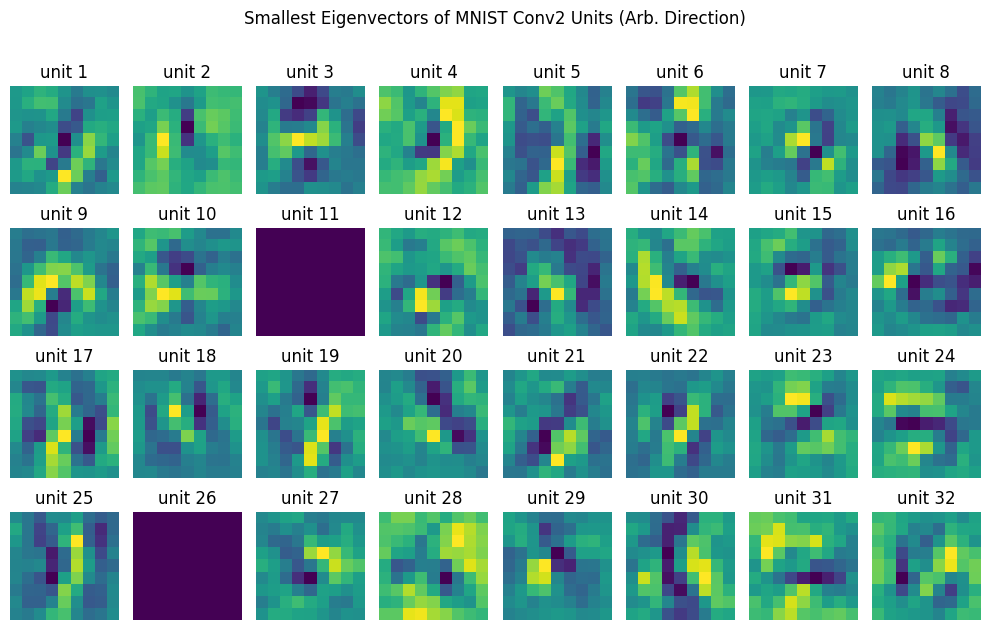

In [542]:
# Absolute = False - Visualise the RWA output as image plots
plt.style.use('default')
for i in range(rf2.shape[0]):
    plt.subplot(4, 8, i+1) # nrows, ncols, index
    plt.axis('off')
    x = eigenvectors2[i, :, 0].reshape(rf_cropped2.shape[1], rf_cropped2.shape[2], rf_cropped2.shape[3])
    to_show = (x - x.min()) / (x.max() - x.min())
    
    # if the unit is not dead (positive activation values)
    if act_conv2[i][act_conv2[i] > 0].shape[0] != 0: # negative activation values are dead units
        to_show = (to_show - to_show.min()) / (to_show.max() - to_show.min()) # normalise to [0, 1]
        plt.imshow(to_show)
    else:
        # show a black image
        plt.imshow(np.zeros((rf2.shape[1], rf2.shape[2], rf2.shape[3])))
    plt.title(f'unit {str(i+1)}', fontsize=12)
    plt.gcf().set_size_inches(7, 7)
    
# title for the entire plot
plt.suptitle(f'Smallest Eigenvectors of MNIST Conv2 Units (Arb. Direction)', fontsize=12)
print(np.round(float(rf2.min()), 3), np.round(float(rf2.max()), 3))
# increase the spacing between subplots
# change figure size
plt.gcf().set_size_inches(10, 6.5)
plt.tight_layout()
plt.subplots_adjust(top=0.88)
plt.show()

-811.224 945.801


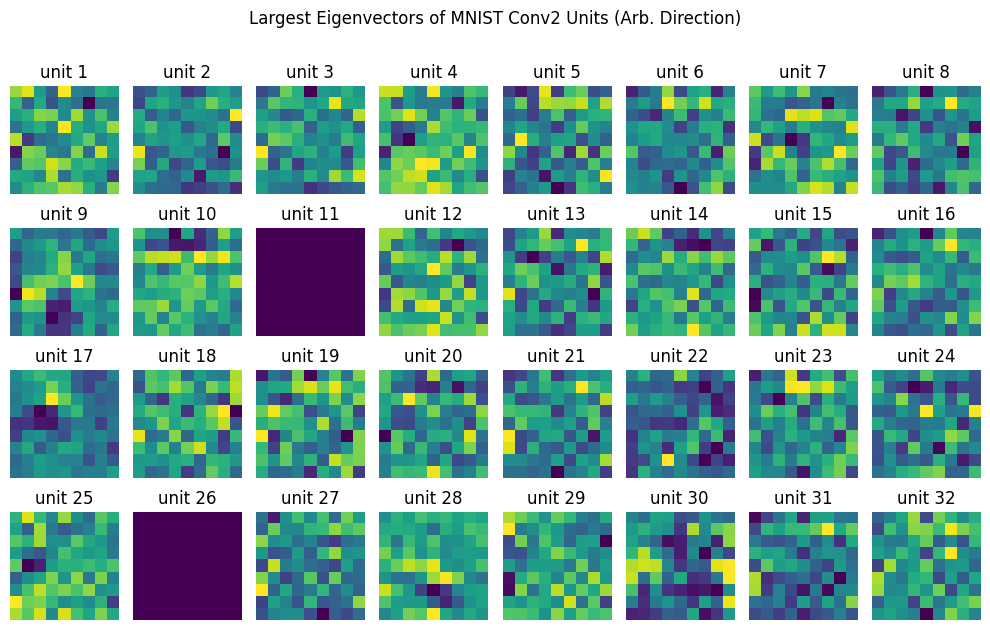

In [543]:
# Absolute = False - Visualise the RWA output as image plots
plt.style.use('default')
for i in range(rf2.shape[0]):
    plt.subplot(4, 8, i+1) # nrows, ncols, index
    plt.axis('off')
    x = eigenvectors2[i, :, -1].reshape(rf_cropped2.shape[1], rf_cropped2.shape[2], rf_cropped2.shape[3])
    to_show = (x - x.min()) / (x.max() - x.min())
    
    # if the unit is not dead (positive activation values)
    if act_conv2[i][act_conv2[i] > 0].shape[0] != 0: # negative activation values are dead units
        to_show = (to_show - to_show.min()) / (to_show.max() - to_show.min()) # normalise to [0, 1]
        plt.imshow(to_show)
    else:
        # show a black image
        plt.imshow(np.zeros((rf2.shape[1], rf2.shape[2], rf2.shape[3])))
    plt.title(f'unit {str(i+1)}', fontsize=12)
    plt.gcf().set_size_inches(7, 7)
    
# title for the entire plot
plt.suptitle(f'Largest Eigenvectors of MNIST Conv2 Units (Arb. Direction)', fontsize=12)
print(np.round(float(rf2.min()), 3), np.round(float(rf2.max()), 3))
# increase the spacing between subplots
# change figure size
plt.gcf().set_size_inches(10, 6.5)
plt.tight_layout()
plt.subplots_adjust(top=0.88)
plt.show()